# Enhanced Image Captioning Model

---

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:685/1*UDOnzqoTnWUQoPP8pZUXgQ.png" alt="Project Overview Concept" width="600">
  <br>
  <small>Sample Model</small>
</p>
<br>

### **University:** Queen Mary University of London
### **Course:** Computational Creativity
### **Professor:** Simon Colton
### **Student:** Erfan Rafieioskouei
<br>

---
<br>

## Project Overview

This project focuses on **Image Captioning**, a multi-modal task at the intersection of Computer Vision and Natural Language Processing. The goal is to generate relevant and descriptive text captions for given input images.

This notebook implements an enhanced image captioning system that goes beyond basic pre-trained models by training a significant component and incorporating additional features for interaction and creativity.

<p align="center">
  <img src="https://placehold.co/600x300/E8E8E8/777777?text=Image+Captioning+Concept\n(Image+In+%E2%86%92+Text+Out)" alt="Image Captioning Concept Diagram">
  <br>
  <small>Conceptual Diagram of Image Captioning</small>
</p>

---

## Technical Approach

The system utilizes a deep learning architecture combining:

1.  **Image Encoding:** A pre-trained **CLIP (ViT-B/32)** model extracts rich, semantically meaningful features from the input image. The CLIP encoder itself is kept frozen to leverage its powerful pre-trained knowledge.
2.  **Caption Decoding:** A **Transformer Decoder** model generates the caption word by word, conditioned on the image features provided by the CLIP encoder.
3.  **Training:** While the CLIP encoder is pre-trained, the Transformer decoder and the interface layers between the encoder and decoder are **trained** within this notebook on the Flickr8k dataset. This allows the model to learn the specific task of generating captions relevant to the dataset's style and content.

<p align="center">
  <img src="https://placehold.co/600x350/E8E8E8/777777?text=Model+Architecture\n(CLIP+Encoder+%E2%86%92+Transformer+Decoder)" alt="Model Architecture Diagram">
  <br>
  <small>Simplified Model Architecture</small>
</p>

---

## Implemented Features & Added Value

This project incorporates several features based on the course requirements and added value criteria:

* **Generative System:** The core functionality is generative – producing novel text (captions) based on image input.
* **Deep Learning:** Leverages state-of-the-art deep learning models (CLIP and Transformer).
* **Training Models:** A key component (the Transformer Decoder) is **trained** as part of the project, demonstrating the ability to adapt and train deep learning architectures rather than solely relying on pre-existing end-to-end models.
* **Multi-modal Capabilities:** Directly addresses a multi-modal task by bridging vision (images) and language (text captions).
* **User Interface:** Implements an interactive **`ipywidgets` interface** within the Colab notebook. This allows users ("casual creators") to easily upload their own images and receive generated captions directly in the notebook environment.
* **Additional Non-Deep Learning Generative Technique:** Includes a **synonym replacement** function using NLTK's WordNet. This post-processes the DL-generated caption to create simple variations, demonstrating an additional, non-DL generative approach.
* **Runs in Colab:** The entire system, including data loading, training, evaluation, and the interactive UI, is designed to run within a Google Colab notebook environment.

*(Note: Addressing higher-level philosophical issues in computational creativity is typically part of the analysis or report accompanying the technical implementation and is not directly coded within the generative system itself.)*


---


# 0. Setup: Environment Configuration and Dependencies

This initial step configures the Colab environment, installs all necessary Python libraries, downloads the required NLTK datasets (including WordNet for synonym replacement), and downloads the Flickr8k image captioning dataset using Kaggle Hub.

**Key actions:**
* **Library Installation:** Installs essential libraries such as `torch`, `transformers`, `nltk`, `openai-clip`, `ipywidgets`, `kagglehub`, and others required for deep learning, image processing, natural language processing, and the interactive UI.
* **NLTK Data Download:** Downloads necessary NLTK resources like 'punkt' (for tokenization), 'wordnet' (for synonym lookup used in later sections), and 'averaged_perceptron_tagger' (for POS tagging).
* **Dataset Download:** Uses `kagglehub` to download and locate the Flickr8k dataset (`adityajn105/flickr8k`). It verifies the paths to the image directory and the caption file (`captions.txt`).
* **Imports:** Imports core Python modules and libraries used throughout the notebook.
* **Warning Suppression:** Configures warnings to be ignored for cleaner output.

In [ ]:
# @title 0. Setup: Download Dataset and Install Libraries

!pip install -q kagglehub ftfy regex tqdm transformers torch torchvision Pillow gradio nltk sentence-transformers openai-clip ipywidgets requests

# Enable ipywidgets extension for Colab (added for display)
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

import kagglehub
import os
import glob # Import glob for file searching
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms # Keep torchvision transforms for image loading/preprocessing before CLIP
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain
import math
import time
import random # Added for synonym replacement probability
import io # Added for handling image bytes in widgets

# NLTK imports
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.corpus import wordnet # Added import for wordnet

# Matplotlib imports
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
import clip # OpenAI CLIP library
from transformers import AutoTokenizer, AutoModel # For potential text processing if needed later
import gradio as gr # For the UI

# ipywidgets imports (added for section 7)
from ipywidgets import FileUpload, Image as IPyImage, Textarea, Button, Output, VBox, HTML, Layout
from IPython.display import display, clear_output


# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Download necessary NLTK data (if not already present)
# Explicitly download required resources
try:
    print("Downloading NLTK 'punkt' resource...")
    nltk.download('punkt', quiet=True)
    print("Downloading NLTK 'punkt_tab' resource...")
    nltk.download('punkt_tab', quiet=True)
    print("Downloading NLTK 'wordnet' resource...")
    nltk.download('wordnet', quiet=True)
    print("Downloading NLTK 'averaged_perceptron_tagger' resource...")
    nltk.download('averaged_perceptron_tagger', quiet=True) # Download the base tagger
    print("Downloading NLTK 'averaged_perceptron_tagger_eng' resource...") # <<< ADD THIS LINE
    nltk.download('averaged_perceptron_tagger_eng', quiet=True) # <<< ADD THIS LINE (Download the specific English tagger)
    # Verify download (optional)
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet.zip') # Adjusted path check for zip
    nltk.data.find('/root/nltk_data/taggers/averaged_perceptron_tagger')
    nltk.data.find('/root/nltk_data/taggers/averaged_perceptron_tagger_eng') # <<< ADD THIS LINE (Verify the English tagger)
    print("Required NLTK resources found/downloaded.")
except Exception as e:
    print(f"An error occurred during NLTK resource download or verification: {e}")
    print("Proceeding, but tokenization or synonym replacement might fail if resources are missing.")


# Download dataset using Kaggle Hub
print("Downloading Flickr8k dataset from Kaggle Hub...")
root = None
image_dir = None
caption_file_path = None
try:
    # Let kagglehub manage the download path automatically
    dataset_path = kagglehub.dataset_download("adityajn105/flickr8k")
    print(f"Dataset downloaded to (or found at): {dataset_path}") # Path usually points to a cache directory

    root = dataset_path # Assume the returned path is the root

    # --- Find the correct image directory ---
    possible_image_dirs = [
        os.path.join(root, "images"),          # Expected structure 1
        os.path.join(root, "Images"),          # Expected structure 2 (case difference)
        os.path.join(root, "Flicker8k_Dataset") # Common alternative name
    ]

    found_image_dir = None
    for dir_path in possible_image_dirs:
        if os.path.isdir(dir_path):
            # Check if it actually contains image files (e.g., .jpg)
            if glob.glob(os.path.join(dir_path, "*.jpg")):
                 found_image_dir = dir_path
                 break # Found a suitable directory

    # If not found in common subdirectories, check if images are directly in the root
    if found_image_dir is None:
         if glob.glob(os.path.join(root, "*.jpg")):
              print("Image files found directly in the root dataset directory.")
              found_image_dir = root # Images are in the root itself
         else:
              print(f"ERROR: Could not find image directory ('images', 'Images', or 'Flicker8k_Dataset') or .jpg files directly within {root}.")
              print("Please check the dataset structure provided by Kaggle Hub.")
              # List contents for debugging:
              try:
                  print(f"Contents of {root}: {os.listdir(root)}")
              except Exception as list_e:
                  print(f"Could not list contents of {root}: {list_e}")

    image_dir = found_image_dir

    # --- Find the caption file ---
    caption_file_path = os.path.join(root, "captions.txt")

    # --- Final Checks ---
    if not os.path.exists(root):
        print(f"ERROR: Root dataset path does not exist: {root}")
        root, image_dir, caption_file_path = None, None, None
    elif image_dir is None or not os.path.exists(image_dir):
         print(f"ERROR: Final image directory path is invalid or not found: {image_dir}")
         root, image_dir, caption_file_path = None, None, None
    elif not os.path.exists(caption_file_path):
        print(f"ERROR: Caption file not found: {caption_file_path}")
        # List contents for debugging:
        try:
            print(f"Contents of {root}: {os.listdir(root)}")
        except Exception as list_e:
            print(f"Could not list contents of {root}: {list_e}")
        root, image_dir, caption_file_path = None, None, None
    else:
        print(f"Dataset root path confirmed: {root}")
        print(f"Image directory confirmed: {image_dir}")
        print(f"Caption file confirmed: {caption_file_path}")

except Exception as e:
    print(f"ERROR: Failed during dataset download or path setup: {e}")
    print("Please ensure Kaggle API credentials are set up if required (e.g., kaggle.json), or check network connection.")
    # Set paths to None to prevent errors later if download fails
    root, image_dir, caption_file_path = None, None, None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.9 MB/s eta 0:00:00
  

## 1. Text Preparation: Building the Vocabulary

This section focuses on processing the raw text captions associated with the Flickr8k images to create a structured vocabulary suitable for the deep learning model. This involves several key steps: cleaning the text, tokenizing it into individual words, and building a mapping between words and unique numerical IDs.

**Core Processes:**

1.  **Reading Captions:**
    * The process starts by reading the captions from the `captions.txt` file.
    * This file typically has a structure like `image_name.jpg,caption text.`. A helper function (`read_caption_file`) parses this format.

2.  **Text Cleaning and Tokenization:**
    * Each caption undergoes cleaning:
        * **Lowercasing:** All text is converted to lowercase to ensure consistency (e.g., "Dog" and "dog" are treated as the same word).
        * **Tokenization:** Captions are split into individual words or tokens using `nltk.word_tokenize`. For example, "A dog is running." becomes `['a', 'dog', 'is', 'running', '.']`.
        * **Punctuation/Non-alphanumeric Removal:** Tokens that are not alphanumeric (like '.') are removed. The example becomes `['a', 'dog', 'is', 'running']`.

    ```
    Conceptual Flow:
    "A little girl climbing..." -> lowercasing -> "a little girl climbing..."
                             -> tokenization -> ['a', 'little', 'girl', 'climbing', ...]
                             -> alphanum filter -> ['a', 'little', 'girl', 'climbing', ...]
    ```

3.  **Vocabulary Construction:**
    * **Word Frequency:** The frequency of each unique word across all cleaned captions is counted.
    * **Handling Infrequent Words:** Words appearing less than a specified threshold (`min_word_freq=4`) are considered infrequent and removed. This helps reduce the vocabulary size and prevents the model from overfitting on rare words. These words are typically mapped to a special `<unk>` (unknown) token later.
    * **Building the Vocabulary Mapping:** A `Vocabulary` object maps each frequent word to a unique integer ID. Special tokens are also added:
        * `<pad>` (ID: 0): Used for padding sequences to the same length within a batch.
        * `<start>` (ID: 1): Marks the beginning of a caption sequence.
        * `<end>` (ID: 2): Marks the end of a caption sequence.
        * `<unk>` (ID: 3): Represents words not in the frequent vocabulary.

    ```
    Vocabulary Mapping Example:
    Word      | ID
    ----------|----
    <pad>     | 0
    <start>   | 1
    <end>     | 2
    <unk>     | 3
    a         | 4
    girl      | 5
    dog       | 6
    running   | 7
    ...       | ...
    ```

4.  **Final Output:**
    * The output of this section includes:
        * A list of all frequent words (`words`).
        * A list of cleaned, tokenized captions (`sentences`), where each caption is a list of words.
        * A corresponding list of image IDs (`image_ids`).
        * The final `Vocabulary` object (`vocab`) containing the word-to-ID mappings.

This prepared text data and vocabulary are essential inputs for creating the dataset and training the caption generation model in subsequent steps.

In [ ]:
# @title Helper function to read caption file (Updated for captions.txt)
def read_caption_file(filepath):
    """ Reads the captions.txt file (format: image_name.jpg,caption). """
    if filepath is None or not os.path.exists(filepath):
        print(f"ERROR: Caption file not found or path is None: {filepath}")
        return None
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            lines = [line.strip() for line in file if line.strip()]
        # Skip header line if present (often 'image,caption')
        if lines and lines[0].lower() == 'image,caption':
            lines = lines[1:]
        return lines
    except Exception as e:
        print(f"ERROR: Could not read caption file {filepath}: {e}")
        return None

In [ ]:
# @title Vocabulary Class
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        # Add special tokens immediately
        self.add_word('<pad>') # Padding token
        self.add_word('<start>') # Start of sequence token
        self.add_word('<end>') # End of sequence token
        self.add_word('<unk>') # Unknown word token

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx.get(word, self.word2idx['<unk>'])

    def __len__(self):
        return len(self.word2idx)

In [ ]:
# @title Text Preparation Function (Updated for captions.txt format)
def TextPreparation(lines, min_word_freq=4):
    """
    Cleans captions from 'image_name.jpg,caption' format, tokenizes, converts to lowercase,
    removes punctuation/infrequent words.

    Args:
        lines (list): List of raw caption lines (e.g., "image_id.jpg,Caption text.").
        min_word_freq (int): Minimum frequency for a word to be included in the vocabulary.

    Returns:
        tuple: (words, sentences, image_ids, infrequent_words)
               - words: List of all frequent words.
               - sentences: List of cleaned, tokenized sentences (list of lists of words).
               - image_ids: List of image IDs (without .jpg) corresponding to each sentence.
               - infrequent_words: Set of words removed due to low frequency.
    """
    if lines is None:
        print("Warning: No caption lines provided to TextPreparation.")
        return [], [], [], set()

    sentences_raw = []
    image_ids_raw = [] # Store IDs with .jpg initially if needed, then strip
    for line in lines:
        parts = line.split(',', 1) # Split only on the first comma
        if len(parts) == 2:
            img_name, caption_part = parts
            img_id = img_name.split('.jpg')[0] # Remove .jpg extension
            sentences_raw.append(caption_part.strip()) # Store raw caption text
            image_ids_raw.append(img_id) # Store ID without extension
        else:
            print(f"Skipping malformed line (expected 'image,caption'): {line}")

    if not sentences_raw:
        print("Warning: No valid captions extracted from the provided lines.")
        return [], [], [], set()

    sentences_cleaned = []
    all_words = []
    valid_indices = [] # Keep track of indices of successfully cleaned sentences

    for i, sentence in enumerate(sentences_raw):
        # Tokenize, remove punctuation, convert to lowercase
        tokens = nltk.word_tokenize(sentence.lower())
        cleaned_tokens = [word for word in tokens if word.isalnum()]
        if cleaned_tokens: # Only add if there are valid tokens
             sentences_cleaned.append(cleaned_tokens)
             all_words.extend(cleaned_tokens)
             valid_indices.append(i) # Store index of the original valid sentence/ID pair

    # Filter image_ids based on valid_indices
    image_ids_cleaned = [image_ids_raw[i] for i in valid_indices]

    if len(image_ids_cleaned) != len(sentences_cleaned):
         # This should ideally not happen with the new logic, but good to check
         print(f"ERROR: Mismatch during cleaning. Cleaned sentences: {len(sentences_cleaned)}, Valid IDs: {len(image_ids_cleaned)}")
         return [], [], [], set()

    # Count word frequencies
    word_counts = Counter(all_words)

    # Identify infrequent words
    infrequent_words = {word for word, count in word_counts.items() if count < min_word_freq}

    # Filter sentences and create the final word list
    final_sentences = []
    final_words = []
    final_image_ids = [] # Use this to ensure alignment
    for i, sentence in enumerate(sentences_cleaned):
        filtered_sentence = [word for word in sentence if word not in infrequent_words]
        if filtered_sentence: # Only keep sentences that are not empty after filtering
            final_sentences.append(filtered_sentence)
            final_words.extend(filtered_sentence)
            final_image_ids.append(image_ids_cleaned[i]) # Append corresponding cleaned image ID


    if len(final_sentences) != len(final_image_ids):
        print(f"ERROR: Mismatch after filtering infrequent words. Sentences: {len(final_sentences)}, IDs: {len(final_image_ids)}")
        return [], [], [], set()

    return final_words, final_sentences, final_image_ids, infrequent_words

In [ ]:
# @title Load and Prepare Captions
# Load raw caption lines from the downloaded file
lines = read_caption_file(caption_file_path)

# Prepare text data
if lines:
    words, sentences, image_ids, infrequent_words = TextPreparation(lines, min_word_freq=4)
    print(f"Total lines read (excluding header): {len(lines)}")
    print(f"Sentences after cleaning & filtering: {len(sentences)}")
    print(f"Image IDs collected: {len(image_ids)}")
    print(f"Total frequent words: {len(words)}")
    print(f"Unique frequent words: {len(set(words))}")
    print(f"Infrequent words removed: {len(infrequent_words)}")
    if sentences:
        print(f"First 3 sentences: {sentences[:3]}")
        print(f"Corresponding Image IDs: {image_ids[:3]}")
    if infrequent_words:
        print(f"First 10 infrequent words: {list(infrequent_words)[:10]}")
else:
    print("Could not load or process caption data. Please check the file path and format.")
    # Handle error appropriately, maybe exit or use dummy data
    words, sentences, image_ids, infrequent_words = [], [], [], set()

Total lines read (excluding header): 40455
Sentences after cleaning & filtering: 40455
Image IDs collected: 40455
Total frequent words: 427668
Unique frequent words: 3385
Infrequent words removed: 5036
First 3 sentences: [['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'way'], ['a', 'girl', 'going', 'into', 'a', 'wooden', 'building'], ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse']]
Corresponding Image IDs: ['1000268201_693b08cb0e', '1000268201_693b08cb0e', '1000268201_693b08cb0e']
First 10 infrequent words: ['maintained', 'civillians', 'sunhat', 'propels', 'whild', 'cruisship', 'west', 'hortons', 'warehouse', 'handout']


In [ ]:
# @title Build Vocabulary
# Create vocab instance
vocab = Vocabulary()

# Add frequent words from the dataset
# Use set(words) to add each unique word only once efficiently
unique_words = set(words)
for word in unique_words:
    vocab.add_word(word)

vocab_size = len(vocab)
print(f"Vocabulary Size (including special tokens): {vocab_size}")
# Display first 10 entries (note: includes special tokens)
print(f"First 10 Vocab Entries (word: id): {dict(list(vocab.word2idx.items())[:10])}")
print(f"First 10 Vocab Entries (id: word): {dict(list(vocab.idx2word.items())[:10])}")


Vocabulary Size (including special tokens): 3389
First 10 Vocab Entries (word: id): {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3, 'rafting': 4, 'chickens': 5, 'performers': 6, 'profile': 7, 'walkway': 8, 'frame': 9}
First 10 Vocab Entries (id: word): {0: '<pad>', 1: '<start>', 2: '<end>', 3: '<unk>', 4: 'rafting', 5: 'chickens', 6: 'performers', 7: 'profile', 8: 'walkway', 9: 'frame'}


## **2. Dataset and Loaders: Preparing Data for the Model**

Once the text vocabulary is built, this section prepares the image and caption data in a format that PyTorch can efficiently use for training, validation, and testing. It involves creating structured datasets and using data loaders for batching and preprocessing. Think of this stage as organizing ingredients (images and captions) and setting up an efficient assembly line (DataLoaders) to feed the model during training.

**Key Components:**

1.  **DataFrame Creation:**
    * A Pandas DataFrame (`data_df`) acts as a central registry, linking each cleaned caption (in its tokenized form) to its corresponding image file path. This structured table makes accessing specific image-caption pairs straightforward.
    * <img src="https://media.geeksforgeeks.org/wp-content/uploads/finallpandas.png" width="500" alt="DataFrame Concept"/> (Illustrates table structure for organizing data)

2.  **PyTorch Dataset (`Flickr8kDataset`):**
    * A custom `Dataset` class (`Flickr8kDataset`) is essential for PyTorch. It acts like a recipe defining how to retrieve and prepare *one single data sample* (an image paired with its caption) when asked.
    * `__len__(self)`: This method simply tells PyTorch the total number of image-caption pairs available in our dataset.
    * `__getitem__(self, index)`: This is the core method. Given an index (a number like asking for the 5th recipe card), it fetches the corresponding image and caption. It performs these crucial steps:
        * Loads the image file using the PIL (Pillow) library.
        * **Applies CLIP Preprocessing:** Instead of generic image transformations (like resizing or normalizing for a standard ResNet), it uses the specific `clip_preprocess` function tied to our loaded CLIP model. This ensures the image is perfectly formatted (correct size, pixel values normalized, etc.) for the CLIP image encoder.
        <img src="https://miro.medium.com/v2/resize:fit:1400/1*P-wDfY9K1DceIHyIkc1p0g.jpeg" width="500" alt="CLIP Preprocessing Concept"/> (Conceptual view of image preparation for CLIP)
        * Converts the tokenized caption (a list of words) into a sequence of numerical IDs using the `vocab` object. It also adds special `<start>` and `<end>` tokens to mark the beginning and end of the sequence. `['a', 'dog', 'runs']` might become `[1, 4, 6, 7, 2]`.
        * Returns the preprocessed image (as a tensor) and the caption (as a tensor of numerical IDs).

3.  **Collate Function (`caption_collate_fn`):**
    * The `DataLoader` (explained next) fetches individual samples using `__getitem__`. However, models train faster on batches of data. The `caption_collate_fn` is a helper function that takes a list of individual samples (e.g., 64 image-caption pairs) and intelligently combines them into a single batch.
    * **Padding:** Captions have different lengths. To create uniform tensors for the batch (which neural networks require), this function finds the longest caption in the batch and pads all shorter captions with a special `<pad>` token's ID (usually 0) until they reach that maximum length.
        <img src="https://i.sstatic.net/UOo7qm.png" width="300" alt="Padding Concept"/> <br>(Illustrates adding padding to make sequences equal length)
    * **Batching Images:** It stacks the individual preprocessed image tensors into a single larger tensor for the batch.
    * Returns the batched images, the padded batched captions, and the original lengths of the captions (useful for some model types, though not strictly necessary for the basic Transformer decoder here).

4.  **Loading CLIP Model & Preprocessor:**
    * Crucially, *before* creating the Datasets, the specific CLIP model (`ViT-B/32`) and its corresponding `clip_preprocess` function are loaded onto the correct device (GPU or CPU).
    * The parameters of CLIP's visual encoder are frozen (`requires_grad_(False)`) because we are using it only as a feature extractor; we won't be training or modifying the CLIP model itself in this project.

5.  **Data Splitting & DataLoader Creation:**
    * **Splitting:** The main DataFrame (`data_df`) is divided into training, validation, and test sets. This split is done carefully based on *unique image IDs*. This ensures that *all* captions for a specific image belong to only one set (e.g., an image doesn't appear in both training and testing), preventing data leakage and leading to a more reliable evaluation of the model's generalization ability.
    * **DataLoaders:** Finally, PyTorch `DataLoader` instances are created for each data split (train, validation, test). They act as efficient managers for the data loading process during training and evaluation:
        * They use the `Flickr8kDataset` to get individual samples.
        * They apply the `caption_collate_fn` to group these samples into batches of a specified `batch_size`.
        * They handle shuffling the training data each epoch (improves learning).
        * They can use multiple worker processes (`num_workers`) to load data in parallel, speeding up the process.
        <img src="https://i.ytimg.com/vi/Sj-gIb0QiRM/hq720.jpg?sqp=-oaymwE7CK4FEIIDSFryq4qpAy0IARUAAAAAGAElAADIQj0AgKJD8AEB-AHUBoAC4AOKAgwIABABGDkgVCh_MA8=&rs=AOn4CLDOyD20QtWVnWdCYAB18QlhV53rHw" width="500" alt="DataLoader Concept"/><br> (Shows how Dataset and DataLoader work together for batching)

This meticulous data preparation pipeline ensures that image-caption pairs are efficiently loaded, correctly preprocessed (specifically for CLIP), batched, and fed to the model in the required tensor formats for effective training and evaluation.

In [ ]:
# @title Create DataFrame
# Ensure alignment between sentences and image_ids before creating DataFrame
if sentences and image_ids and len(sentences) == len(image_ids) and image_dir:
    cleaned_captions_text = [' '.join(s) for s in sentences]
    # Construct full image paths
    image_paths = []
    missing_images = 0
    for img_id in image_ids:
        path = os.path.join(image_dir, img_id + ".jpg")
        if not os.path.exists(path):
            # print(f"Warning: Image file not found: {path}") # Can be verbose
            missing_images += 1
        image_paths.append(path)

    if missing_images > 0:
        print(f"Warning: {missing_images} image files referenced in captions were not found in {image_dir}")

    data = {
        'image_id': image_ids,
        'path': image_paths,
        'caption_tokens': sentences, # Store tokenized captions
        'caption_text': cleaned_captions_text # Store text captions for reference
    }
    data_df = pd.DataFrame(data)

    print(f"DataFrame created with {len(data_df)} entries.")
    print(data_df.head())
else:
    print(f"ERROR: Cannot create DataFrame. Sentences: {len(sentences)}, Image IDs: {len(image_ids)}, Image Dir: {image_dir}")
    data_df = pd.DataFrame() # Create empty DataFrame to avoid later errors


DataFrame created with 40455 entries.
                image_id                                               path  \
0  1000268201_693b08cb0e  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  1000268201_693b08cb0e  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  1000268201_693b08cb0e  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  1000268201_693b08cb0e  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  1000268201_693b08cb0e  /kaggle/input/flickr8k/Images/1000268201_693b0...   

                                      caption_tokens  \
0  [a, child, in, a, pink, dress, is, climbing, u...   
1        [a, girl, going, into, a, wooden, building]   
2  [a, little, girl, climbing, into, a, wooden, p...   
3  [a, little, girl, climbing, the, stairs, to, h...   
4  [a, little, girl, in, a, pink, dress, going, i...   

                                        caption_text  
0  a child in a pink dress is climbing up a set o...  
1                a girl going into a woo

In [ ]:
# @title Flickr8k Dataset Class
class Flickr8kDataset(Dataset):
    """Flickr8k custom dataset compatible with torch.utils.data.DataLoader."""

    def __init__(self, df, vocab, clip_preprocess):
        """
        Args:
            df (pd.DataFrame): DataFrame containing image paths and tokenized captions.
            vocab (Vocabulary): Vocabulary wrapper.
            clip_preprocess: The preprocessing function from the loaded CLIP model.
        """
        self.df = df
        self.vocab = vocab
        self.clip_preprocess = clip_preprocess # Use CLIP's preprocessing

    def __getitem__(self, index):
        """Returns one data pair (image tensor and caption tensor)."""
        vocab = self.vocab
        # Ensure index is within bounds
        if index >= len(self.df):
             raise IndexError("Index out of bounds")

        tokens = self.df['caption_tokens'].iloc[index]
        path = self.df['path'].iloc[index]

        try:
            # Load image using PIL
            pil_image = Image.open(open(path, 'rb')).convert("RGB")
            # Preprocess image using CLIP's function
            image = self.clip_preprocess(pil_image)
        except FileNotFoundError:
            # print(f"Warning: Image file not found at {path}. Skipping index {index}.") # Verbose
            # Return None, handled by collate_fn
            return None
        except Exception as e:
            print(f"Warning: Error loading/processing image {path}: {e}. Skipping index {index}.")
            return None

        # Convert caption (list of tokens) to word ids.
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.tensor(caption, dtype=torch.long) # Use torch.long for embedding indices

        return image, target

    def __len__(self):
        return len(self.df)

In [ ]:
# @title Collate Function for Padding
def caption_collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption). Handles None items."""
    # Filter out None items resulting from loading errors in __getitem__
    data = [item for item in data if item is not None]
    if not data:
        return None, None, None # Return None if batch is empty after filtering

    # Sort by caption length (descending) - helps potentially with packed sequences later, though not strictly needed for Transformer
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Stack images (CLIP preprocessor outputs tensors)
    images = torch.stack(images, 0)

    # Pad captions
    lengths = [len(cap) for cap in captions]
    # Use vocab.<pad> ID for padding
    pad_id = vocab('<pad>') # Get pad ID from vocab instance
    targets = torch.full((len(captions), max(lengths)), pad_id, dtype=torch.long) # Fill with pad ID
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    # Return lengths as a tensor as well
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)

    return images, targets, lengths_tensor

In [ ]:
# @title Load CLIP Model and Preprocessor
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the CLIP model and preprocessing function
# Using ViT-B/32 as a common choice. Others available: 'RN50', 'RN101', 'RN50x4', 'ViT-L/14' etc.
try:
    # Check if model needs downloading or is cached
    print("Loading CLIP model (ViT-B/32)...")
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print("CLIP model (ViT-B/32) and preprocessor loaded successfully.")
    # Freeze CLIP model parameters if not fine-tuning the image encoder
    for param in clip_model.parameters():
        param.requires_grad_(False)
    clip_model.eval() # Set to evaluation mode
except Exception as e:
    print(f"Error loading CLIP model: {e}")
    clip_model, clip_preprocess = None, None # Handle error

Using device: cuda
Loading CLIP model (ViT-B/32)...


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 153MiB/s]


CLIP model (ViT-B/32) and preprocessor loaded successfully.


In [ ]:
# @title Create Datasets and DataLoaders
if not data_df.empty and clip_preprocess is not None and vocab:
    # --- Data Splitting ---
    # Split based on unique image IDs to prevent data leakage between sets
    unique_image_ids = data_df['image_id'].unique()
    np.random.seed(42) # for reproducibility
    np.random.shuffle(unique_image_ids)

    # Define split ratios
    train_split_ratio = 0.8 # 80% for training
    val_split_ratio = 0.1   # 10% for validation
    test_split_ratio = 0.1  # 10% for testing

    # Calculate split indices
    num_unique_images = len(unique_image_ids)
    train_end_idx = int(num_unique_images * train_split_ratio)
    val_end_idx = train_end_idx + int(num_unique_images * val_split_ratio)

    # Get sets of image IDs for each split
    train_ids = set(unique_image_ids[:train_end_idx])
    val_ids = set(unique_image_ids[train_end_idx:val_end_idx])
    test_ids = set(unique_image_ids[val_end_idx:])

    # Create boolean masks for the DataFrame
    train_mask = data_df['image_id'].isin(train_ids)
    val_mask = data_df['image_id'].isin(val_ids)
    test_mask = data_df['image_id'].isin(test_ids)

    # Create DataFrames for each split
    df_train = data_df[train_mask].reset_index(drop=True)
    df_val = data_df[val_mask].reset_index(drop=True)
    df_test = data_df[test_mask].reset_index(drop=True)

    print(f"Total unique images: {num_unique_images}")
    print(f"Training images: {len(train_ids)} ({len(df_train)} captions)")
    print(f"Validation images: {len(val_ids)} ({len(df_val)} captions)")
    print(f"Test images: {len(test_ids)} ({len(df_test)} captions)")

    # --- Create Dataset instances ---
    try:
        dataset_train = Flickr8kDataset(df_train, vocab, clip_preprocess)
        dataset_val = Flickr8kDataset(df_val, vocab, clip_preprocess)
        dataset_test = Flickr8kDataset(df_test, vocab, clip_preprocess)
        print("PyTorch Datasets created.")
    except Exception as e:
        print(f"Error creating Dataset instances: {e}")
        dataset_train, dataset_val, dataset_test = None, None, None


    # --- Define batch size ---
    batch_size = 64 # Adjust based on GPU memory and dataset size

    # --- Create DataLoader instances ---
    if dataset_train and dataset_val and dataset_test:
        train_loader = DataLoader(
            dataset=dataset_train,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2, # Adjust based on system (0 or 2 often good for Colab)
            collate_fn=caption_collate_fn,
            pin_memory=True # Helps speed up data transfer to GPU if using CUDA
        )

        val_loader = DataLoader(
            dataset=dataset_val,
            batch_size=batch_size, # Use same batch size or smaller for validation
            shuffle=False, # No need to shuffle validation/test
            num_workers=2,
            collate_fn=caption_collate_fn,
            pin_memory=True
        )

        # Use batch size 1 for test loader to evaluate images individually
        test_loader = DataLoader(
            dataset=dataset_test,
            batch_size=1,
            shuffle=False,
            num_workers=2,
            collate_fn=caption_collate_fn
        )
        print("DataLoaders created.")
    else:
         print("Could not create DataLoaders because Datasets failed.")
         train_loader, val_loader, test_loader = None, None, None

else:
    print("DataFrame is empty, CLIP model not loaded, or Vocab not built. Cannot create Datasets/DataLoaders.")
    train_loader, val_loader, test_loader = None, None, None
    # Assign empty df just in case it's needed later to avoid errors
    if 'data_df' not in locals(): data_df = pd.DataFrame()

Total unique images: 8091
Training images: 6472 (32360 captions)
Validation images: 809 (4045 captions)
Test images: 810 (4050 captions)
PyTorch Datasets created.
DataLoaders created.


## **3. Model Architecture: CLIP Encoder + Transformer Decoder**

This section defines the core deep learning model responsible for generating captions. We move beyond simpler architectures by combining a powerful pre-trained image encoder (CLIP) with a sophisticated text generator (Transformer Decoder).

**Conceptual Overview:**

The architecture follows an **Encoder-Decoder** pattern, common in sequence-to-sequence tasks like machine translation and, in this case, image-to-text generation.

<img src="https://www.mdpi.com/applsci/applsci-11-06975/article_deploy/html/images/applsci-11-06975-g001-550.jpg"/><br>
(Conceptual Diagram: Image features are encoded, then decoded into a text sequence)

**Key Components:**

1.  **Encoder (`EncoderCLIP`):**
    * **Role:** Extracts meaningful features from the input image. Instead of training an image encoder from scratch (like a ResNet), we leverage the pre-trained visual part of CLIP (`ViT-B/32`).
    * **Mechanism:**
        * Takes the preprocessed image tensor as input.
        * Passes it through CLIP's frozen visual transformer (`clip_model.visual`) to get a rich feature vector (embedding). Using CLIP provides features that understand image content in relation to text concepts.
        * **Projection Layer:** Since the Transformer Decoder expects features of a specific dimension (`embed_size`), a Linear layer (`fc`) projects the output features from CLIP's dimension to this target `embed_size`.
        * **Batch Normalization:** A BatchNorm layer (`bn`) helps stabilize the feature values, potentially aiding training convergence.
        * **Output:** A single feature vector (per image in the batch) representing the image's content, ready to be passed to the decoder.
    

2.  **Positional Encoding (`PositionalEncoding`):**
    * **Role:** Transformers, unlike RNNs/LSTMs, don't inherently process sequences in order. They look at the entire sequence at once (using attention). Positional Encoding injects information about the *position* of each word in the caption sequence.
    * **Mechanism:** It creates fixed sine and cosine wave patterns based on the position in the sequence and the embedding dimension. These positional signals are *added* to the word embeddings before they enter the Transformer Decoder. This allows the model to understand word order (e.g., "dog bites man" vs. "man bites dog").<br>
    <img src="https://machinelearningmastery.com/wp-content/uploads/2022/01/PE3.png" width="400" alt="Positional Encoding Concept"/><br>
        (Visual representation of positional encoding patterns)

3.  **Decoder (`DecoderTransformer`):**
    * **Role:** Generates the caption word by word, conditioned on the image features from the `EncoderCLIP`.
    * **Mechanism:**
        * **Word Embeddings:** Converts input caption words (represented by numerical IDs) into dense vectors (`embedding`).
        * **Positional Encoding:** Adds the positional signals to the word embeddings.
        * **Transformer Decoder Layers:** The core of the decoder. It uses multiple layers, each typically containing:
            * *Self-Attention:* Allows the decoder to weigh the importance of different words in the caption generated *so far* when predicting the next word. Uses a "masked" self-attention mechanism so it can only attend to previous words, not future ones (essential for generation).
            * *Encoder-Decoder Attention:* Allows the decoder to focus on the relevant parts of the *image features* (provided by the `memory` input from the `EncoderCLIP`) when generating each word.
            * *Feed-Forward Network:* Further processes the information within each layer.
        * **Output Layer:** A final Linear layer (`fc_out`) maps the decoder's output vectors back to the size of the vocabulary, producing probability scores for each possible next word.<br>
    <img src="https://miro.medium.com/v2/resize:fit:1400/0*vMWwPCVAbvcSQn6L" width="400" alt="Transformer Decoder Layer Concept"/><br>
        (Diagram showing the components within a single Transformer Decoder layer)
    * **Generation (`sample` method):** During inference, it starts with a `<start>` token, uses the image features, predicts the next word (greedily picking the highest probability), feeds that predicted word back in, and repeats until an `<end>` token is generated or a maximum length is reached.

**Connection:** The `EncoderCLIP` produces a fixed-size image feature vector (`memory`). This vector is fed into *each* Transformer Decoder layer, specifically into the Encoder-Decoder Attention mechanism, guiding the word-by-word generation process based on the image content.

In [ ]:
# @title Positional Encoding
class PositionalEncoding(nn.Module):
    """Injects positional information into the input embeddings."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe) # register_buffer ensures it's part of the model state but not trained

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        # Ensure positional encoding is on the same device as x
        self.pe = self.pe.to(x.device)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [ ]:
# @title CLIP Encoder Wrapper
class EncoderCLIP(nn.Module):
    def __init__(self, clip_model, embed_size):
        super(EncoderCLIP, self).__init__()
        # Store the main clip model to access its dtype easily
        self.clip_model_ref = clip_model
        self.clip = clip_model.visual # Use the visual part of CLIP
        # CLIP output size depends on the model (e.g., 512 for ViT-B/32, 768 for ViT-L/14)
        clip_output_size = self.clip.output_dim
        self.fc = nn.Linear(clip_output_size, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01) # Batch norm can help stabilize training

        # Freeze CLIP parameters (already done during loading, but good practice)
        for param in self.clip.parameters():
            param.requires_grad_(False)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad(): # Ensure no gradients calculated for CLIP

            # Ensure images are on the correct device first
            images_on_device = images.to(self.fc.weight.device)
            # Cast to the dtype of the loaded clip_model
            features = self.clip(images_on_device.to(self.clip_model_ref.dtype))
            # ----------------------------------------------------------------------
        # features shape: [batch_size, clip_output_size]

        # Project features to embed_size
        features = self.fc(features.type(self.fc.weight.dtype)) # Cast features to the dtype of fc.weight
        # Apply batch norm only if batch size > 1 during training
        if self.training and features.size(0) > 1:
             features = self.bn(features)
        elif not self.training: # Apply batch norm in eval mode using running stats
             # Check if features is not empty before applying bn
             if features.nelement() > 0:
                 features = self.bn(features)
        # features shape: [batch_size, embed_size]
        return features

In [ ]:
# @title Transformer Decoder Model
class DecoderTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, nhead, num_decoder_layers, dim_feedforward, dropout=0.1, max_seq_length=50, pad_id=0, start_id=1, end_id=2):
        super(DecoderTransformer, self).__init__()
        self.embed_size = embed_size
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_id) # Use padding_idx
        self.pos_encoder = PositionalEncoding(embed_size, dropout, max_len=max_seq_length+1) # Max length for PE
        # Transformer Decoder Layer - Using standard PyTorch convention (batch_first=False)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.max_seq_length = max_seq_length
        self.vocab_size = vocab_size

        # Special token IDs passed during initialization
        self.pad_id = pad_id
        self.start_id = start_id
        self.end_id = end_id


    def _generate_square_subsequent_mask(self, sz, device):
        """Generates a square causal mask for the sequence. The masked positions are filled with float('-inf')."""
        mask = (torch.triu(torch.ones(sz, sz, device=device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def _make_tgt_padding_mask(self, tgt):
        """Creates a padding mask for the target sequence (batch_first=False)."""
        # tgt shape: [seq_len, batch_size]
        # Output shape: [batch_size, seq_len] - True where padded
        return (tgt == self.pad_id).transpose(0, 1) # Transpose to get [batch, seq]

    def forward(self, memory, captions):
        """
        Decodes image feature vectors and generates captions during training.
        Args:
            memory: Image features from encoder, shape [batch_size, embed_size]
            captions: Ground truth captions (padded), shape [batch_size, seq_len]
                      Assumes captions include <start> and <end> tokens.
        """
        # Prepare target input (exclude <end> token) and target output (exclude <start> token)
        # Need shape [seq_len, batch_size] for standard Transformer modules
        captions_input = captions[:, :-1].transpose(0, 1) # Shape: [seq_len - 1, batch_size]
        captions_target = captions[:, 1:].transpose(0, 1) # Shape: [seq_len - 1, batch_size]

        tgt_seq_len = captions_input.size(0)
        device = captions.device # Get device from input tensor

        # Create masks
        # Target mask prevents attending to future tokens (causal mask)
        tgt_mask = self._generate_square_subsequent_mask(tgt_seq_len, device) # Shape: [tgt_seq_len, tgt_seq_len]
        # Target padding mask prevents attending to padding tokens in the input sequence
        tgt_padding_mask = self._make_tgt_padding_mask(captions_input) # Shape: [batch_size, tgt_seq_len]

        # Embed captions and add positional encoding
        # Shape: [seq_len, batch_size, embed_size]
        tgt_emb = self.embedding(captions_input) * math.sqrt(self.embed_size) # Scale embedding
        tgt_emb = self.pos_encoder(tgt_emb) # PositionalEncoding expects [seq, batch, embed]

        # Prepare memory for decoder: Shape [memory_seq_len=1, batch_size, embed_size]
        memory = memory.unsqueeze(0) # Add sequence dimension

        # Decode
        output = self.transformer_decoder(
            tgt=tgt_emb,                  # [tgt_len, batch, embed]
            memory=memory,                # [mem_len=1, batch, embed]
            tgt_mask=tgt_mask,            # [tgt_len, tgt_len]
            tgt_key_padding_mask=tgt_padding_mask # [batch, tgt_len]
            # memory_key_padding_mask=None (since mem_len=1, no padding needed)
        )
        # output shape: [tgt_len, batch_size, embed_size]

        # Final linear layer
        output = self.fc_out(output)
        # output shape: [tgt_len, batch_size, vocab_size]

        # For CrossEntropyLoss, we need [N, C] where N is num_samples, C is num_classes
        # Reshape output: [tgt_len * batch_size, vocab_size]
        reshaped_output = output.reshape(-1, output.shape[2])

        # Reshape target (excluding <start> token): [tgt_len * batch_size]
        reshaped_target = captions_target.reshape(-1)

        return reshaped_output, reshaped_target # Return reshaped output and target for loss calculation

    def sample(self, features, states=None, max_len=None, method='greedy'):
        """
        Generate captions for given image features using greedy search.
        Args:
            features: Image features from encoder, shape [batch_size, embed_size]
            states: Not used in Transformer.
            max_len: Maximum length of generated caption. Defaults to self.max_seq_length.
            method: 'greedy'. Beam search not implemented.

        Returns:
            sampled_ids: List of lists containing generated caption IDs (variable length).
        """
        if max_len is None:
            max_len = self.max_seq_length

        batch_size = features.size(0)
        device = features.device
        generated_sequences = [[] for _ in range(batch_size)] # Store sequences for each batch item
        finished = [False] * batch_size

        # Prepare initial input: <start> token for each batch item
        # Shape: [1, batch_size]
        current_input_ids = torch.full((1, batch_size), self.start_id, dtype=torch.long, device=device)

        # Prepare memory: [1, batch_size, embed_size]
        memory = features.unsqueeze(0) # Add sequence dimension (length 1)

        with torch.no_grad(): # No need to track gradients during inference
            for i in range(max_len):
                # Embed current input sequence
                # Shape: [current_seq_len, batch_size, embed_size]
                embedded_input = self.embedding(current_input_ids) * math.sqrt(self.embed_size)
                embedded_input = self.pos_encoder(embedded_input)

                # Create causal mask for the current sequence length
                # Shape: [current_seq_len, current_seq_len]
                tgt_mask = self._generate_square_subsequent_mask(current_input_ids.size(0), device)

                # Pass through Transformer decoder
                # Output shape: [current_seq_len, batch_size, embed_size]
                output = self.transformer_decoder(
                    tgt=embedded_input,
                    memory=memory,
                    tgt_mask=tgt_mask
                    # No padding mask needed during step-by-step generation
                )

                # Get the prediction for the *last* token in the sequence
                # Shape: [batch_size, embed_size]
                last_output = output[-1, :, :]
                # Pass through final linear layer
                # Shape: [batch_size, vocab_size]
                predictions = self.fc_out(last_output)

                if method == 'greedy':
                    # Get the token with the highest probability
                    # Shape: [batch_size]
                    predicted_ids = predictions.argmax(dim=1)
                else:
                    raise NotImplementedError("Only 'greedy' sampling is implemented.")

                # Update generated sequences and check for finished sequences
                predicted_ids_list = predicted_ids.tolist()
                all_finished = True
                for b in range(batch_size):
                    if not finished[b]:
                        token_id = predicted_ids_list[b]
                        if token_id == self.end_id:
                            finished[b] = True
                        else:
                            generated_sequences[b].append(token_id)
                            # Keep track that at least one sequence is still generating
                            all_finished = False

                # If all sequences have generated <end>, stop early
                if all_finished:
                    break

                # Prepare input for the next step: append the predicted IDs
                # Shape: [1, batch_size]
                next_token_tensor = predicted_ids.unsqueeze(0)
                # Shape: [new_seq_len, batch_size]
                current_input_ids = torch.cat([current_input_ids, next_token_tensor], dim=0)

                # Optional: Limit memory usage if sequences get very long
                # if current_input_ids.size(0) > some_threshold:
                #     current_input_ids = current_input_ids[-some_threshold:, :]

        # Return the generated sequences (list of lists of IDs)
        return generated_sequences

In [ ]:
# @title Model and Training Parameters
# Hyperparameters
embed_size = 512       # Dimension of embeddings and Transformer model (matches CLIP ViT-B/32 output)
nhead = 8              # Number of attention heads in Transformer
num_decoder_layers = 4 # Number of Transformer decoder layers (reduced from 6 for potentially faster training)
dim_feedforward = 1024 # Dimension of the feedforward network (reduced)
dropout = 0.1          # Dropout rate
learning_rate = 2e-4   # Learning rate (adjust based on training)
num_epochs = 10        # Number of epochs (adjust based on convergence)
log_step = 100         # Print log every N steps
save_step = 1          # Save model every N epochs
max_seq_length = 35    # Maximum caption length for generation/PE

# Model saving directory (using dataset root from Kaggle download)
if root: # Check if root path is valid
    model_save_dir = "/kaggle/working/models_clip_transformer/"  # Use /kaggle/working/
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
        print(f"Created model save directory: {model_save_dir}")
else:
    model_save_dir = "./models_clip_transformer/" # Fallback to local dir
    if not os.path.exists(model_save_dir): os.makedirs(model_save_dir)
    print(f"Warning: Dataset root path not set, using local directory for models: {model_save_dir}")



Created model save directory: /kaggle/working/models_clip_transformer/


In [ ]:
# @title Initialize Models, Loss, Optimizer
# Ensure CLIP model and vocab are loaded
if clip_model is None or vocab is None or vocab_size <= 4: # Vocab size check
    raise RuntimeError("CLIP model failed to load or vocabulary is empty. Cannot initialize models.")

# Get special token IDs from vocab
pad_id = vocab('<pad>')
start_id = vocab('<start>')
end_id = vocab('<end>')

# Build the models
encoder = EncoderCLIP(clip_model, embed_size).to(device)
decoder = DecoderTransformer(
    vocab_size=vocab_size,
    embed_size=embed_size,
    nhead=nhead,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    max_seq_length=max_seq_length,
    pad_id=pad_id,
    start_id=start_id,
    end_id=end_id
).to(device)

# Loss function - Ignore padding index
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

# Optimizer - only optimize decoder parameters and the encoder's final FC/BN layers
# CLIP visual backbone is frozen
params_to_optimize = list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters())
optimizer = optim.AdamW(params_to_optimize, lr=learning_rate, weight_decay=1e-4) # AdamW is often preferred

# Learning rate scheduler (optional but recommended)
# Example: Reduce learning rate when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

print("Encoder, Decoder, Criterion, Optimizer initialized.")
print(f"Vocabulary Size: {vocab_size}")
print(f"Pad ID: {pad_id}, Start ID: {start_id}, End ID: {end_id}")
print(f"Number of parameters to train: {sum(p.numel() for p in params_to_optimize if p.requires_grad):,}")


Encoder, Decoder, Criterion, Optimizer initialized.
Vocabulary Size: 3389
Pad ID: 0, Start ID: 1, End ID: 2
Number of parameters to train: 16,355,133


## **4. Training Loop**

This section implements the core training process where the model learns to generate captions from images. The loop iterates through the training data multiple times (epochs), updating the model's parameters (specifically, the Transformer Decoder and the projection layer in the Encoder) to minimize the difference between its generated captions and the ground truth captions.

**Conceptual Flow:**

<img src="https://miro.medium.com/v2/resize:fit:644/1*FKXBbirB2-E42_QRTtTpfw.png" width="200" alt="Training Loop Concept"/><br>
(Diagram showing the cyclical nature of a training loop: forward pass, loss calculation, backward pass, parameter update)

**Key Steps within the `train_model` function:**

1.  **Epoch Iteration:** The outer loop iterates for a specified number of `num_epochs`. An epoch represents one full pass through the entire training dataset.

2.  **Training Phase (per Epoch):**
    * **Set Models to Train Mode:** `encoder.train()` and `decoder.train()` are called. This activates certain layers like Dropout (in the Decoder) and uses batch statistics for BatchNorm (in the Encoder's projection layer), which is desirable during training.
    * **Batch Iteration:** The inner loop iterates through the `train_loader`, processing one batch of images and captions at a time.
    * **Data to Device:** The current batch of images and captions is moved to the designated `device` (GPU or CPU).
    * **Zero Gradients:** `optimizer.zero_grad()` clears gradients from the previous batch to prevent accumulation.
    * **Forward Pass:**
        * The images are passed through the `EncoderCLIP` to obtain image feature vectors (`features`).
        * These `features` and the corresponding ground truth `captions` (excluding the `<end>` token) are fed into the `DecoderTransformer`.
        * The decoder predicts the probability distribution over the vocabulary for each position in the output sequence.
    * **Loss Calculation:**
        * The `criterion` (CrossEntropyLoss) calculates the difference (loss) between the decoder's predictions (`outputs`) and the actual target words (`targets`, which are the ground truth captions shifted by one position, excluding the `<start>` token). CrossEntropyLoss is suitable for multi-class classification tasks like predicting the next word in a sequence. It ignores the `<pad>` token index during calculation.<br>
        <img src="https://miro.medium.com/v2/resize:fit:616/1*N1PyOYeog-vyytRbwEwQCQ.png" width="300" alt="Loss Calculation Concept"/><br>
        (Conceptual: Measuring the difference between predicted output and target)
    * **Backward Pass:** `loss.backward()` computes the gradients of the loss with respect to the model's trainable parameters (Decoder parameters and Encoder's fc/bn layers). This tells us how much each parameter contributed to the error.
        
    * **Gradient Clipping:** `torch.nn.utils.clip_grad_norm_` prevents gradients from becoming too large (exploding gradients), which can destabilize training, especially in complex models like Transformers. It caps the gradients at a specified maximum norm (`max_norm=1.0`).
    * **Optimizer Step:** `optimizer.step()` updates the model's trainable parameters based on the calculated gradients and the chosen optimization algorithm (AdamW), moving the parameters in the direction that minimizes the loss.

3.  **Validation Phase (per Epoch):**
    * **Set Models to Eval Mode:** `encoder.eval()` and `decoder.eval()` deactivate Dropout and make BatchNorm use its learned running statistics, ensuring consistent evaluation.
    * **No Gradient Calculation:** `torch.no_grad()` temporarily disables gradient calculation, saving memory and computation during validation as we are only evaluating, not training.
    * **Iterate through `val_loader`:** The loop processes batches from the validation set.
    * **Calculate Validation Loss:** Performs the forward pass and calculates the loss using the same criterion as in training. The average loss over the entire validation set is computed. This provides an unbiased estimate of how well the model generalizes to unseen data.

4.  **Learning Rate Scheduling:**
    * `scheduler.step(avg_val_loss)` adjusts the learning rate based on the validation loss. The `ReduceLROnPlateau` scheduler decreases the learning rate (e.g., by half) if the validation loss stops improving for a set number of epochs (`patience`), helping the model fine-tune its parameters more effectively.

5.  **Model Checkpointing:**
    * **Best Model:** If the current epoch's validation loss is the best seen so far, the model's state (parameters, optimizer state, vocab, hyperparameters) is saved to `best_model.pth.tar`. This ensures we always keep the version of the model that performed best on the validation set.
    * **Periodic Checkpoints:** The model state is also saved periodically (e.g., every `save_step` epochs) to `checkpoint_epoch_{epoch+1}.pth.tar`. This allows resuming training from a specific epoch if needed.

6.  **Early Stopping:**
    * If the validation loss doesn't improve for a predefined number of epochs (`patience`), the training loop stops early to prevent overfitting and save time.

This comprehensive loop ensures the model learns effectively by iteratively processing data, calculating errors, updating weights, monitoring performance on validation data, adjusting the learning rate, and saving the best-performing model.
<br><br>

In [ ]:
# @title Training Function
def train_model(encoder, decoder, criterion, optimizer, scheduler, train_loader, val_loader, vocab, num_epochs, device, log_step, save_step, model_save_dir, patience=3):
    """Trains the image captioning model."""

    start_time = time.time()
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    # Ensure data loaders are available
    if train_loader is None or val_loader is None:
        print("ERROR: DataLoaders not initialized. Cannot start training.")
        return [], [] # Return empty lists

    total_steps = len(train_loader)
    if total_steps == 0:
        print("ERROR: Training loader has no batches. Check dataset/dataloader setup.")
        return [], []

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        encoder.train() # Train mode (only affects BN layer in encoder)
        decoder.train() # Train mode (affects dropout)
        running_loss = 0.0
        steps_processed = 0

        for i, batch_data in enumerate(train_loader):
            # Handle potential empty batches from collate_fn filtering
            if batch_data is None or batch_data[0] is None:
                # print(f"Skipping potentially empty batch {i+1}/{total_steps}") # Can be verbose
                continue

            images, captions, lengths = batch_data # lengths not directly used by this Transformer forward
            images = images.to(device)
            captions = captions.to(device) # Shape: [batch_size, seq_len]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            features = encoder(images) # Shape: [batch_size, embed_size]
            # Decoder forward expects memory [batch, embed], captions [batch, seq]
            outputs, targets = decoder(features, captions) # Returns reshaped [N, C], [N]

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            # Gradient clipping (optional but often helpful with Transformers)
            torch.nn.utils.clip_grad_norm_(params_to_optimize, max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            steps_processed += 1

            # Print log info
            if (i + 1) % log_step == 0:
                # Calculate loss for this interval
                current_step_loss = loss.item() # Loss of the current step
                avg_interval_loss = running_loss / steps_processed # Avg loss since last log
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Current Loss: {current_step_loss:.4f}, Avg Interval Loss: {avg_interval_loss:.4f}')
                # Reset running loss and steps_processed for the next logging interval
                # running_loss = 0.0
                # steps_processed = 0

        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / steps_processed if steps_processed > 0 else 0
        train_losses.append(avg_train_loss)

        # --- Validation Phase ---
        encoder.eval() # Eval mode
        decoder.eval() # Eval mode
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for batch_data_val in val_loader:
                 if batch_data_val is None or batch_data_val[0] is None: continue # Skip empty batches

                 images_val, captions_val, lengths_val = batch_data_val
                 images_val = images_val.to(device)
                 captions_val = captions_val.to(device)

                 features_val = encoder(images_val)
                 outputs_val, targets_val = decoder(features_val, captions_val)
                 loss_val = criterion(outputs_val, targets_val)
                 val_loss += loss_val.item()
                 val_steps += 1

        avg_val_loss = val_loss / val_steps if val_steps > 0 else 0
        val_losses.append(avg_val_loss)

        epoch_time = time.time() - epoch_start_time
        print(f'\n--- Epoch {epoch+1}/{num_epochs} Summary ---')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Time Elapsed: {epoch_time/60:.2f} minutes')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}') # Display current learning rate
        print('---------------------------\n')

        # Learning rate scheduling step based on validation loss
        scheduler.step(avg_val_loss)

        # Save the model checkpoint if validation loss improved
        if avg_val_loss < best_val_loss:
            print(f'Validation loss decreased ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model...')
            best_val_loss = avg_val_loss
            epochs_no_improve = 0 # Reset patience counter
            # Ensure save directory exists
            if not os.path.exists(model_save_dir): os.makedirs(model_save_dir)
            # Save checkpoint
            torch.save({
                'epoch': epoch + 1,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss,
                'vocab': vocab, # Save vocab for inference
                'embed_size': embed_size, # Save necessary hyperparameters
                'nhead': nhead,
                'num_decoder_layers': num_decoder_layers,
                'dim_feedforward': dim_feedforward,
                'max_seq_length': max_seq_length,
                'pad_id': pad_id,
                'start_id': start_id,
                'end_id': end_id
            }, os.path.join(model_save_dir, 'best_model.pth.tar'))
        else:
            epochs_no_improve += 1
            print(f'Validation loss did not improve for {epochs_no_improve} epoch(s).')

        # Optional: Save checkpoint every 'save_step' epochs regardless of improvement
        if (epoch + 1) % save_step == 0 and save_step > 0:
             print(f'Saving checkpoint at epoch {epoch+1}...')
             if not os.path.exists(model_save_dir): os.makedirs(model_save_dir)
             torch.save({
                'epoch': epoch + 1,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss, # Save current best val loss
                'vocab': vocab,
                'embed_size': embed_size,
                'nhead': nhead,
                'num_decoder_layers': num_decoder_layers,
                'dim_feedforward': dim_feedforward,
                'max_seq_length': max_seq_length,
                'pad_id': pad_id,
                'start_id': start_id,
                'end_id': end_id
             }, os.path.join(model_save_dir, f'checkpoint_epoch_{epoch+1}.pth.tar'))


        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss.')
            break

    total_training_time = time.time() - start_time
    print(f'\n--- Training Finished ---')
    print(f'Total Training Time: {total_training_time/60:.2f} minutes ({total_training_time:.2f} seconds)')
    print(f'Best Validation Loss: {best_val_loss:.4f}')

    return train_losses, val_losses

Starting training for 10 epochs...
Epoch [1/10], Step [100/506], Current Loss: 4.0758, Avg Interval Loss: 4.9207
Epoch [1/10], Step [200/506], Current Loss: 3.5887, Avg Interval Loss: 4.3968
Epoch [1/10], Step [300/506], Current Loss: 3.4685, Avg Interval Loss: 4.1123
Epoch [1/10], Step [400/506], Current Loss: 3.2676, Avg Interval Loss: 3.9249
Epoch [1/10], Step [500/506], Current Loss: 3.0319, Avg Interval Loss: 3.7826

--- Epoch 1/10 Summary ---
Average Training Loss: 3.7754
Validation Loss: 3.1146
Time Elapsed: 2.55 minutes
Current LR: 0.000200
---------------------------

Validation loss decreased (inf --> 3.1146). Saving model...
Saving checkpoint at epoch 1...
Epoch [2/10], Step [100/506], Current Loss: 2.9571, Avg Interval Loss: 3.0006
Epoch [2/10], Step [200/506], Current Loss: 3.0427, Avg Interval Loss: 2.9704
Epoch [2/10], Step [300/506], Current Loss: 2.8621, Avg Interval Loss: 2.9373
Epoch [2/10], Step [400/506], Current Loss: 2.8694, Avg Interval Loss: 2.9092
Epoch [2/10]

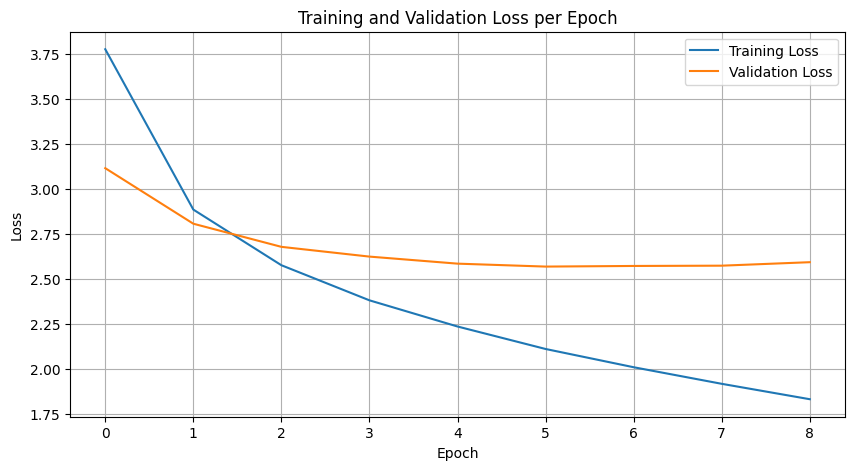

In [ ]:
# @title Start Training
# Ensure loaders are ready before starting training
if train_loader and val_loader and encoder and decoder and criterion and optimizer and scheduler and vocab:
    train_losses, val_losses = train_model(
        encoder, decoder, criterion, optimizer, scheduler,
        train_loader, val_loader, vocab, num_epochs, device,
        log_step, save_step, model_save_dir, patience=3 # Added patience here
    )

    # Plotting the training and validation loss (only if training ran)
    if train_losses or val_losses:
        plt.figure(figsize=(10, 5))
        if train_losses: plt.plot(train_losses, label='Training Loss')
        if val_losses: plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        # Save the plot
        plot_save_path = os.path.join(model_save_dir, 'loss_plot.png')
        plt.savefig(plot_save_path)
        print(f"Loss plot saved to {plot_save_path}")
        plt.show()
    else:
        print("No losses recorded, skipping plot.")
else:
    print("Skipping training due to missing components (Loaders, Models, Vocab, etc.). Check previous steps for errors.")


## **5. Evaluation and Inference**

After training the model, this section focuses on two key tasks: evaluating its performance objectively on unseen test data and setting up the functions needed to generate captions for new, arbitrary images (inference).

**Key Processes:**

1.  **Loading the Best Model (`load_checkpoint`):**
    * Before evaluation or inference, we need to load the best-performing model saved during training (usually the one with the lowest validation loss).
    * The `load_checkpoint` function handles this:
        * It takes the path to the saved checkpoint file (`best_model.pth.tar`).
        * It loads the saved dictionary containing model state dictionaries (for the encoder's projection layer and the decoder), optimizer state, vocabulary (`vocab`), and crucial hyperparameters (like `embed_size`, `nhead`, etc.).
        * It re-initializes the `EncoderCLIP` and `DecoderTransformer` architectures using the saved hyperparameters.
        * It loads the saved state dictionaries into these newly initialized models.
        * It sets the models to evaluation mode (`.eval()`), which is important for consistent results during inference (disables dropout, etc.).
        * It also loads the pre-trained CLIP model and its preprocessor again, as they are needed by the `EncoderCLIP` wrapper and the caption generation function.
    * This ensures we are using the optimal version of our trained components for testing and generating new captions.

2.  **Inference - Generating Captions (`generate_caption`):**
    * This function takes a new image (either a file path or a PIL Image object) and generates a descriptive caption using the loaded, trained model.
    * **Steps:**
        * **Preprocessing:** The input image is preprocessed using the `clip_preprocess` function to match the format expected by CLIP.
        * **Encoding:** The preprocessed image tensor is passed through the loaded `EncoderCLIP` to get the image feature vector.
        * **Decoding (Sampling):** The `decoder.sample()` method performs the step-by-step caption generation:
            * It starts with the special `<start>` token ID.
            * In a loop (up to `max_len`):
                * It feeds the current sequence of generated token IDs and the image features into the Transformer Decoder.
                * The decoder predicts the probability distribution for the *next* word over the entire vocabulary.
                * **Greedy Search:** It selects the word ID with the highest probability as the next word in the sequence.
                * This predicted word ID is added to the sequence.
                * The loop continues until the decoder predicts the `<end>` token ID or the maximum length is reached.
        * **Conversion to Text:** The resulting sequence of generated word IDs is converted back into readable words using the loaded `vocab`. Special tokens are handled appropriately.
        * **Output:** Returns the final generated caption as a string.

3.  **Evaluation (`evaluate_model`):**
    * This function assesses the quality of the captions generated by the model compared to the human-provided reference captions on the test dataset.
    * **Metric: BLEU Score:** Bilingual Evaluation Understudy (BLEU) is a common metric for evaluating machine-generated text against reference texts. It measures the overlap of n-grams (sequences of n words) between the candidate (generated) caption and the reference captions. Higher BLEU scores generally indicate better similarity.
        * *BLEU-1:* Measures overlap of individual words (unigrams).
        * *BLEU-2:* Measures overlap of word pairs (bigrams).
        * *BLEU-3, BLEU-4:* Measure overlap of trigrams and 4-grams, respectively. Higher-order BLEU scores focus more on fluency and phrase matching.<br>
    <img src="https://miro.medium.com/v2/resize:fit:1400/0*whwVqqHaR9lXqgea" width="500" alt="BLEU Score Concept"/><br>
      (Evaluating Text Generation with N-gram Precision)
    * **Process:**
        * Iterates through the `test_loader` (ideally with `batch_size=1` for easier reference handling).
        * For each test image, it generates a candidate caption using `generate_caption`.
        * **Reference Grouping:** Crucially, for a proper evaluation (especially Corpus BLEU), it retrieves *all* the human reference captions associated with that specific test image from the `df_test` DataFrame.
        * **Calculation:**
            * *Sentence BLEU (Average):* The code calculates BLEU scores for each generated caption against *one* of its references (the one paired in the dataloader batch) and averages these scores across the test set. Smoothing is applied to handle cases with zero overlap.
            * *Corpus BLEU:* It also calculates the overall Corpus BLEU score. This method considers all generated captions and all corresponding reference captions together, providing a more robust single score for the entire test set by aggregating n-gram counts *before* calculating the final precision score.
        * **Reporting:** Prints both the Corpus BLEU scores (1-4) and the average Sentence BLEU scores (1-4) for comparison. Corpus BLEU is generally preferred for overall model evaluation.

4.  **Display Sample:** Finally, a random sample from the test set is chosen, its image is displayed, the reference captions are printed, and the caption generated by the loaded model is shown for qualitative assessment.

In [ ]:
# @title Load Best Model Function
def load_checkpoint(checkpoint_path, device):
    """Loads the saved model checkpoint."""
    if not os.path.exists(checkpoint_path):
        print(f"ERROR: Checkpoint file not found at {checkpoint_path}")
        return None, None, None, None # Return None for models, vocab, clip_preprocess

    print(f"Loading checkpoint from {checkpoint_path}...")
    try:
        # --- FIX: Set weights_only=False to load checkpoints with pickled data ---
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        # ------------------------------------------------------------------------
    except Exception as e:
        print(f"Error loading checkpoint file: {e}")
        # Add more specific error handling if needed based on common issues
        if "Unsupported global" in str(e):
             print("This might be due to a custom class (like Vocabulary) saved in the checkpoint.")
             print("Ensure the Vocabulary class definition is available before calling load_checkpoint.")
        return None, None, None, None

    # Load necessary components from checkpoint
    loaded_vocab = checkpoint.get('vocab')
    loaded_embed_size = checkpoint.get('embed_size')
    loaded_nhead = checkpoint.get('nhead')
    loaded_num_decoder_layers = checkpoint.get('num_decoder_layers')
    loaded_dim_feedforward = checkpoint.get('dim_feedforward')
    loaded_max_seq_length = checkpoint.get('max_seq_length', 50) # Default if not saved
    loaded_pad_id = checkpoint.get('pad_id', 0)
    loaded_start_id = checkpoint.get('start_id', 1)
    loaded_end_id = checkpoint.get('end_id', 2)
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    start_epoch = checkpoint.get('epoch', 0) # Epoch *after* which this was saved

    if not all([loaded_vocab, loaded_embed_size, loaded_nhead, loaded_num_decoder_layers, loaded_dim_feedforward]):
         print("ERROR: Checkpoint is missing essential hyperparameter information.")
         return None, None, None, None
    # --- Add check for Vocabulary class type ---
    if not isinstance(loaded_vocab, Vocabulary):
         print(f"ERROR: Loaded vocab is not of type Vocabulary (found {type(loaded_vocab)}). Checkpoint might be corrupted or saved incorrectly.")
         return None, None, None, None
    # ------------------------------------------

    # Re-initialize models with saved hyperparameters
    # Need CLIP model again for EncoderCLIP initialization
    try:
        print("Loading CLIP model (ViT-B/32) for inference...")
        clip_model_inf, clip_preprocess_inf = clip.load("ViT-B/32", device=device)
        clip_model_inf.eval() # Set to eval mode
    except Exception as e:
        print(f"Error loading CLIP model for inference: {e}")
        return None, None, None, None

    # Pass the loaded clip_model_inf to EncoderCLIP
    encoder_inf = EncoderCLIP(clip_model_inf, loaded_embed_size).to(device)
    decoder_inf = DecoderTransformer(
        vocab_size=len(loaded_vocab),
        embed_size=loaded_embed_size,
        nhead=loaded_nhead,
        num_decoder_layers=loaded_num_decoder_layers,
        dim_feedforward=loaded_dim_feedforward,
        max_seq_length=loaded_max_seq_length,
        pad_id=loaded_pad_id,
        start_id=loaded_start_id,
        end_id=loaded_end_id
    ).to(device)

    # Load state dictionaries
    try:
        encoder_inf.load_state_dict(checkpoint['encoder_state_dict'])
        decoder_inf.load_state_dict(checkpoint['decoder_state_dict'])
    except KeyError as e:
        print(f"Error: Missing key in checkpoint state_dict: {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading state dictionaries: {e}")
        return None, None, None, None


    encoder_inf.eval() # Set to evaluation mode
    decoder_inf.eval() # Set to evaluation mode

    print(f"Checkpoint loaded successfully. Model trained for {start_epoch} epochs with best validation loss: {best_val_loss:.4f}")

    return encoder_inf, decoder_inf, loaded_vocab, clip_preprocess_inf # Return clip_preprocess as wel

In [ ]:
# @title Generate Caption Function (using loaded components)
def generate_caption(image_input, encoder, decoder, vocab, clip_preprocess, device, max_len=30):
    """
    Generates a caption for a single image (path or PIL Image).
    Args:
        image_input (str or PIL.Image): Path to the image file or a PIL Image object.
        encoder: Loaded encoder model.
        decoder: Loaded decoder model.
        vocab: Loaded vocabulary object.
        clip_preprocess: Loaded CLIP preprocessing function.
        device: Device to run inference on.
        max_len: Maximum caption length.
    Returns:
        str: Generated caption string.
    """
    if not all([encoder, decoder, vocab, clip_preprocess]):
        return "Error: Model components not loaded."

    encoder.eval()
    decoder.eval()

    try:
        if isinstance(image_input, str): # If input is a path
            pil_image = Image.open(image_input).convert("RGB")
        elif isinstance(image_input, Image.Image): # If input is a PIL image
            pil_image = image_input.convert("RGB")
        else:
            return "Error: Invalid image input type (expected path string or PIL Image)."

        # Preprocess image and add batch dimension
        image_tensor = clip_preprocess(pil_image).unsqueeze(0).to(device)

        with torch.no_grad():
            features = encoder(image_tensor) # Shape: [1, embed_size]
            # Sample function returns list of lists, get the first list for batch size 1
            sampled_ids_list = decoder.sample(features, max_len=max_len, method='greedy')[0]

        # Convert word IDs to words
        caption_words = []
        for word_id in sampled_ids_list: # No numpy conversion needed
            word = vocab.idx2word.get(word_id)
            if word is None or word == vocab.idx2word[vocab('<pad>')]: # Check for None or padding
                word = vocab.idx2word[vocab('<unk>')] # Fallback to unknown
            # No need to check for start/end here as sample() should handle it

            caption_words.append(word)

        return ' '.join(caption_words).strip() # Join and strip potential whitespace

    except FileNotFoundError:
        return f"Error: Image not found at {image_input}"
    except Exception as e:
        return f"Error generating caption: {e}"

In [ ]:
# Import necessary libraries (ensure matplotlib, numpy, nltk, time, os, torch, PIL are imported)
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import time
import os
import torch
import torch.nn as nn
from PIL import Image

# Assuming the following are defined globally or passed correctly:
# encoder_best, decoder_best, vocab_loaded, test_loader, device, clip_preprocess_inf,
# data_df_test, max_seq_length, dataset_test, generate_caption, model_save_dir

# Define Vocabulary class if not already defined in the scope
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx.get(word, self.word2idx['<unk>'])

    def __len__(self):
        return len(self.word2idx)

# Ensure the generate_caption function is defined or imported here
# Example placeholder (replace with your actual function if needed):
# def generate_caption(img_path_test, encoder, decoder, vocab, clip_preprocess_inf, device, max_len):
#     try:
#         # ... [Your caption generation logic] ...
#         # Simulate output
#         caption_ids = [vocab('<start>'), vocab('a'), vocab('test'), vocab('image'), vocab('<end>')]
#         caption_words = [vocab.idx2word.get(idx, '<unk>') for idx in caption_ids[1:-1]]
#         return ' '.join(caption_words)
#     except Exception as e:
#         print(f"Error in dummy generate_caption: {e}")
#         return "<error>"


# Modified Evaluate on Test Set function
def evaluate_model(encoder, decoder, vocab, test_loader, device, data_df_test):
    """
    Evaluates the model on the test set using BLEU score and plots both
    Corpus and Avg Sentence BLEU results side-by-side.
    Args:
        encoder: Loaded encoder model.
        decoder: Loaded decoder model.
        vocab: Loaded vocabulary object.
        test_loader: DataLoader for the test set (batch size 1 recommended).
        device: Device for inference.
        data_df_test: DataFrame containing test data (needed to group references).
    """
    # --- [Existing code for checks and model setup] ---
    if test_loader is None:
        print("ERROR: Test loader not available. Cannot evaluate.")
        return
    # Check if dataset_test is available globally or within the scope
    if 'dataset_test' not in globals() or dataset_test is None:
        print("ERROR: Test dataset object (dataset_test) not found. Cannot evaluate.")
        return
    if data_df_test.empty:
        print("ERROR: Test DataFrame is empty. Cannot group references for proper evaluation.")
        return
    # Check if generate_caption is defined
    if 'generate_caption' not in globals() or not callable(generate_caption):
         print("ERROR: generate_caption function is not defined or not callable.")
         return

    encoder.eval()
    decoder.eval()

    # --- Prepare for Corpus BLEU ---
    references_grouped = {}
    if not data_df_test.empty:
         print("Grouping references by image ID for Corpus BLEU calculation...")
         for img_id, group in data_df_test.groupby('image_id'):
             refs = [nltk.word_tokenize(cap.lower()) for cap in group['caption_text']]
             references_grouped[img_id] = refs
         print(f"Grouped references for {len(references_grouped)} unique images.")

    # --- Generate Candidates and Calculate BLEU ---
    candidates = {}
    processed_images = set()
    bleu_scores_sent = {'BLEU-1': [], 'BLEU-2': [], 'BLEU-3': [], 'BLEU-4': []}
    smoothie = SmoothingFunction().method4 # Smoothing for sentence BLEU
    start_eval_time = time.time()
    processed_count = 0

    with torch.no_grad():
        for i, batch_data_test in enumerate(test_loader):
             if batch_data_test is None or batch_data_test[0] is None: continue

             images_test, captions_test, _ = batch_data_test
             image_test = images_test.to(device)

             current_index = i
             if current_index < len(dataset_test):
                 img_id_test = dataset_test.df['image_id'].iloc[current_index]
                 img_path_test = dataset_test.df['path'].iloc[current_index]
             else:
                 print(f"Warning: Index {current_index} out of bounds for test dataset ({len(dataset_test)}).")
                 continue

             if img_id_test in processed_images:
                 continue
             processed_images.add(img_id_test)

             # Generate candidate caption
             try:
                 candidate_caption_text = generate_caption(img_path_test, encoder, decoder, vocab, clip_preprocess_inf, device, max_len=max_seq_length)
                 candidate_tokens = nltk.word_tokenize(candidate_caption_text.lower())
                 candidates[img_id_test] = candidate_tokens
             except Exception as gen_e:
                 print(f"Error generating caption for {img_id_test}: {gen_e}")
                 continue

             # --- Calculate Sentence BLEU ---
             caption_ref_ids = captions_test[0].cpu().numpy()
             reference_words = []
             for word_id in caption_ref_ids:
                 if word_id == vocab.word2idx['<start>'] or word_id == vocab.word2idx['<pad>']: continue
                 if word_id == vocab.word2idx['<end>']: break
                 reference_words.append(vocab.idx2word.get(word_id, '<unk>'))

             if reference_words and candidate_tokens:
                 try:
                     # Ensure reference_words is wrapped in a list for sentence_bleu
                     bleu1 = sentence_bleu([reference_words], candidate_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
                     bleu2 = sentence_bleu([reference_words], candidate_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
                     bleu3 = sentence_bleu([reference_words], candidate_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
                     bleu4 = sentence_bleu([reference_words], candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
                     bleu_scores_sent['BLEU-1'].append(bleu1)
                     bleu_scores_sent['BLEU-2'].append(bleu2)
                     bleu_scores_sent['BLEU-3'].append(bleu3)
                     bleu_scores_sent['BLEU-4'].append(bleu4)
                 except Exception:
                     pass

             processed_count += 1
             if (processed_count) % 100 == 0:
                 print(f"Processed {processed_count}/{len(references_grouped)} unique test images...")

    eval_time = time.time() - start_eval_time
    print(f"\n--- Evaluation Finished ---")
    print(f"Time Elapsed: {eval_time/60:.2f} minutes")
    print(f"Processed {processed_count} unique images.")

    # --- Calculate and Print Corpus BLEU ---
    bleu1_corpus, bleu2_corpus, bleu3_corpus, bleu4_corpus = 0.0, 0.0, 0.0, 0.0
    corpus_scores = [] # Reset and store calculated scores for plotting
    if references_grouped and candidates:
        print("\nCalculating Corpus BLEU scores...")
        list_of_references = []
        hypotheses = []
        for img_id in references_grouped.keys():
            if img_id in candidates:
                list_of_references.append(references_grouped[img_id])
                hypotheses.append(candidates[img_id])

        if list_of_references and hypotheses:
            try:
                # Use nltk.translate.bleu_score.corpus_bleu
                bleu1_corpus = corpus_bleu(list_of_references, hypotheses, weights=(1, 0, 0, 0))
                bleu2_corpus = corpus_bleu(list_of_references, hypotheses, weights=(0.5, 0.5, 0, 0))
                bleu3_corpus = corpus_bleu(list_of_references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
                bleu4_corpus = corpus_bleu(list_of_references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
                corpus_scores = [bleu1_corpus, bleu2_corpus, bleu3_corpus, bleu4_corpus] # Store for plot
                print(f"Corpus BLEU-1: {bleu1_corpus:.4f}")
                print(f"Corpus BLEU-2: {bleu2_corpus:.4f}")
                print(f"Corpus BLEU-3: {bleu3_corpus:.4f}")
                print(f"Corpus BLEU-4: {bleu4_corpus:.4f}")
            except Exception as e:
                 print(f"An error occurred during Corpus BLEU calculation: {e}")
        else:
             print("Not enough matching references and candidates for Corpus BLEU.")

    # --- Report Average Sentence BLEU ---
    avg_bleu1, avg_bleu2, avg_bleu3, avg_bleu4 = 0.0, 0.0, 0.0, 0.0
    sentence_scores = [] # Reset and store calculated scores for plotting
    if processed_count > 0 and bleu_scores_sent['BLEU-1']:
        print("\nAverage Sentence BLEU scores:")
        avg_bleu1 = np.mean(bleu_scores_sent['BLEU-1'])
        avg_bleu2 = np.mean(bleu_scores_sent['BLEU-2'])
        avg_bleu3 = np.mean(bleu_scores_sent['BLEU-3'])
        avg_bleu4 = np.mean(bleu_scores_sent['BLEU-4'])
        sentence_scores = [avg_bleu1, avg_bleu2, avg_bleu3, avg_bleu4] # Store for plot
        print(f"Avg Sent BLEU-1: {avg_bleu1:.4f}")
        print(f"Avg Sent BLEU-2: {avg_bleu2:.4f}")
        print(f"Avg Sent BLEU-3: {avg_bleu3:.4f}")
        print(f"Avg Sent BLEU-4: {avg_bleu4:.4f}")
    else:
        print("\nNo samples were processed for sentence BLEU evaluation.")

    # --- Plotting Both BLEU Scores ---
    # Ensure we have scores to plot
    if corpus_scores and sentence_scores: # Check if both lists are populated
        print("\nGenerating Combined BLEU Score Plot...")
        plt.figure(figsize=(10, 6)) # Adjusted figure size for clarity
        bleu_types = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
        index = np.arange(len(bleu_types))
        bar_width = 0.35

        # Plotting Corpus BLEU scores
        bars1 = plt.bar(index, corpus_scores, bar_width, color='skyblue', label='Corpus BLEU')
        # Plotting Avg Sentence BLEU scores
        bars2 = plt.bar(index + bar_width, sentence_scores, bar_width, color='lightcoral', label='Avg Sentence BLEU')

        # Adding labels and title
        plt.xlabel('BLEU Score Type')
        plt.ylabel('Score')
        plt.title('Corpus vs. Average Sentence BLEU Score Results')
        plt.xticks(index + bar_width / 2, bleu_types) # Position ticks between the grouped bars
        # Calculate dynamic y-limit based on the max score found
        max_score = 0
        if corpus_scores: max_score = max(max_score, max(corpus_scores))
        if sentence_scores: max_score = max(max_score, max(sentence_scores))
        plt.ylim(0, max_score * 1.2 if max_score > 0 else 1) # Adjust y-limit

        plt.legend()
        plt.grid(axis='y', linestyle='--')

        # Helper function to add labels to bars
        def add_labels(bars):
             for bar in bars:
                 yval = bar.get_height()
                 # Only display label if yval is not NaN or Inf
                 if np.isfinite(yval):
                     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom', fontsize=9)

        # Display the scores on the bars
        add_labels(bars1)
        add_labels(bars2)

        plt.tight_layout()
        plt.show()
    else:
        print("\nNot enough data to plot both Corpus and Average Sentence BLEU scores.")

Loading checkpoint from /kaggle/working/models_clip_transformer/best_model.pth.tar...
Loading CLIP model (ViT-B/32) for inference...
Checkpoint loaded successfully. Model trained for 6 epochs with best validation loss: 2.5680
Grouping references by image ID for Corpus BLEU calculation...
Grouped references for 810 unique images.
Processed 100/810 unique test images...
Processed 200/810 unique test images...
Processed 300/810 unique test images...
Processed 400/810 unique test images...
Processed 500/810 unique test images...
Processed 600/810 unique test images...
Processed 700/810 unique test images...
Processed 800/810 unique test images...

--- Evaluation Finished ---
Time Elapsed: 1.14 minutes
Processed 810 unique images.

Calculating Corpus BLEU scores...
Corpus BLEU-1: 0.6453
Corpus BLEU-2: 0.4790
Corpus BLEU-3: 0.3453
Corpus BLEU-4: 0.2373

Average Sentence BLEU scores:
Avg Sent BLEU-1: 0.3239
Avg Sent BLEU-2: 0.2014
Avg Sent BLEU-3: 0.1376
Avg Sent BLEU-4: 0.0938

Generating Co

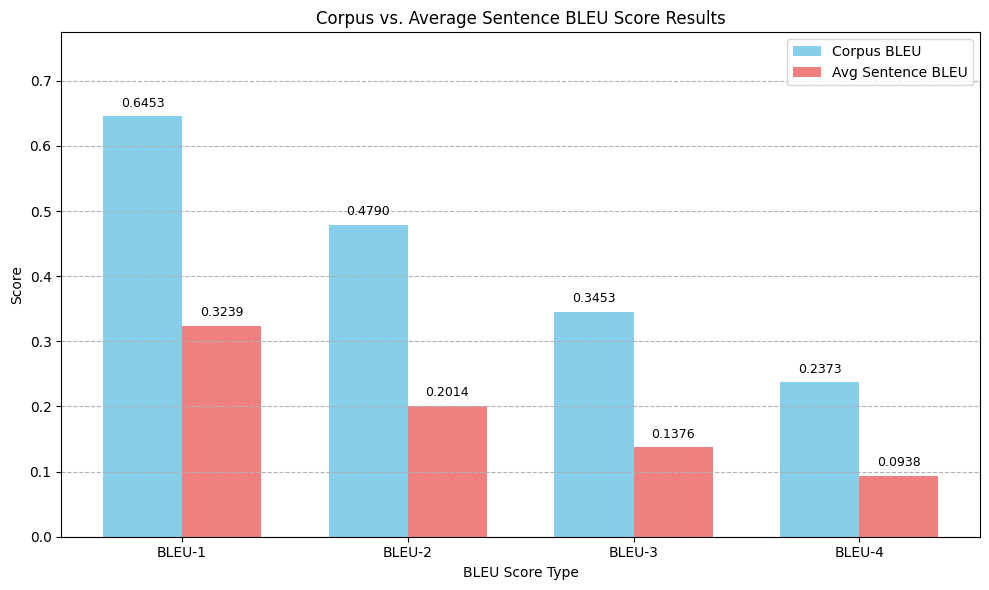

In [ ]:
# @title Load and Evaluate
# Load the best model
checkpoint_path = os.path.join(model_save_dir, 'best_model.pth.tar')
encoder_best, decoder_best, vocab_loaded, clip_preprocess_inf = load_checkpoint(checkpoint_path, device)

# Evaluate if model loaded and test_loader exists
# Need df_test for grouping references in evaluate_model
if encoder_best and decoder_best and vocab_loaded and clip_preprocess_inf and test_loader and 'df_test' in locals() and not df_test.empty and 'dataset_test' in locals() and dataset_test:
    evaluate_model(encoder_best, decoder_best, vocab_loaded, test_loader, device, df_test)
else:
    print("\nSkipping evaluation due to missing components (Model, Vocab, Test Loader, Test DataFrame, or Test Dataset).")
    # Assign defaults if missing to prevent errors in next cell
    if 'encoder_best' not in locals(): encoder_best = None
    if 'decoder_best' not in locals(): decoder_best = None
    if 'vocab_loaded' not in locals(): vocab_loaded = None
    if 'clip_preprocess_inf' not in locals(): clip_preprocess_inf = None
    if 'dataset_test' not in locals(): dataset_test = None

--- Displaying 2 Random Samples ---

--- Sample 1/2 ---
Image Path: /kaggle/input/flickr8k/Images/3415228562_4efa9c9b70.jpg


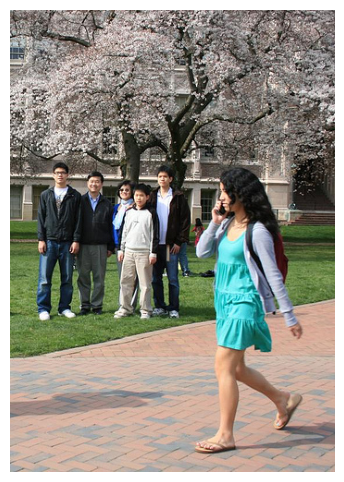


Reference Captions:
- a family is watching a girl on the phone walk by
- a girl in a dress walks while a family stands in the background
- a woman walks and talks on her cellphone while nearby men watch
- a woman wearing a blue dress walking by a group of staring guys
- lady on a cellphone walking in front of a group of men

Generated Caption: a group of people walking down a sidewalk
--------------------

--- Sample 2/2 ---
Image Path: /kaggle/input/flickr8k/Images/2801851082_8c3c480c0f.jpg


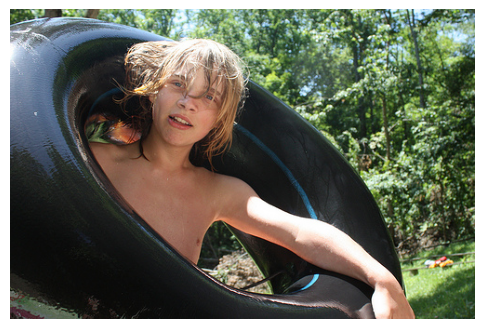


Reference Captions:
- a blond boy with a rubber innertube over his shoulder
- a boy holding a float
- a boy plays with a water tube
- a kid without a shirt uses an innertube for shade
- a young blond boy with long hair with a large innertube around his body

Generated Caption: a boy in a black shirt and blue shorts is sliding down a water slide
--------------------


In [ ]:
# @title Display 10 Sample Images and Generated Captions
# Display sample images from the test set and their generated captions
if encoder_best and decoder_best and vocab_loaded and clip_preprocess_inf and dataset_test:
    # Ensure dataset_test is not empty
    if len(dataset_test) == 0:
        print("Test dataset is empty. Cannot display samples.")
    else:
        num_samples_to_show = 2
        if len(dataset_test) < num_samples_to_show:
            print(f"Warning: Test dataset has fewer than {num_samples_to_show} samples. Showing all {len(dataset_test)}.")
            num_samples_to_show = len(dataset_test)

        # Get unique random indices
        sample_indices = random.sample(range(len(dataset_test)), num_samples_to_show)

        print(f"--- Displaying {num_samples_to_show} Random Samples ---")

        for i, sample_idx in enumerate(sample_indices):
            print(f"\n--- Sample {i+1}/{num_samples_to_show} ---")
            try:
                # __getitem__ returns image tensor and caption tensor, or None
                item = dataset_test[sample_idx]

                if item:
                    # Need image path and reference text from the dataframe
                    img_path_sample = dataset_test.df['path'].iloc[sample_idx]
                    # Get *all* reference captions for this image for display
                    img_id_sample = dataset_test.df['image_id'].iloc[sample_idx]
                    reference_captions_sample = dataset_test.df[dataset_test.df['image_id'] == img_id_sample]['caption_text'].tolist()

                    # Generate caption using the function
                    generated_caption_sample = generate_caption(img_path_sample, encoder_best, decoder_best, vocab_loaded, clip_preprocess_inf, device, max_len=max_seq_length)

                    # Display
                    print(f"Image Path: {img_path_sample}")
                    # Check if image file exists before trying to read
                    if os.path.exists(img_path_sample):
                        img_display = mpimg.imread(img_path_sample)
                        plt.figure(figsize=(6, 6)) # Adjust figure size for better display
                        plt.imshow(img_display)
                        plt.axis('off')
                        plt.show()
                    else:
                        print(f"Image file not found at: {img_path_sample}")

                    print(f"\nReference Captions:")
                    for ref in reference_captions_sample:
                        print(f"- {ref}")
                    print(f"\nGenerated Caption: {generated_caption_sample}")
                else:
                     print(f"Could not load sample item at index {sample_idx}.")

            except IndexError:
                 print(f"Error: Index {sample_idx} out of bounds for test dataset.")
            except FileNotFoundError:
                 print(f"Error: Sample image file not found during display for index {sample_idx}.")
            except Exception as e:
                print(f"Error displaying sample {i+1}: {e}")
            print("-" * 20) # Separator between samples

else:
    print("\nCannot display samples, required components (model, vocab, preprocessor, test dataset) not available.")

## **6. Non-DL Generative Technique: Synonym Replacement**

Beyond the primary deep learning model, this section introduces an additional, simpler generative technique to create variations of the captions. This method operates *after* the main caption is generated and does not involve deep learning itself. Instead, it uses classic Natural Language Processing (NLP) techniques from the NLTK library, specifically leveraging WordNet to replace certain words with their synonyms. This adds a layer of "computational creativity" by producing alternative phrasings.

**Core Process (`generate_caption_variation`):**

1.  **Input:** Takes the caption string generated by the Transformer Decoder model.

2.  **Tokenization & POS Tagging:**
    * The input caption is first broken down into individual words (tokens) using `nltk.word_tokenize`.
    * Each token is then tagged with its Part-of-Speech (POS) – identifying whether it's a noun, verb, adjective, adverb, etc., using `nltk.pos_tag`. This is crucial because synonym replacement makes more sense for certain word types (like nouns, verbs, adjectives) than others (like prepositions or articles).<br>
    <img src="https://cdn-media-1.freecodecamp.org/images/1*f6e0uf5PX17pTceYU4rbCA.jpeg" width="500" alt="POS Tagging Concept"/> <br>
      (Conceptual example of Part-of-Speech tagging)

3.  **WordNet POS Mapping (`get_wordnet_pos`):**
    * NLTK's POS tags (like 'NN' for noun, 'VB' for verb) need to be mapped to the format WordNet understands (e.g., `wordnet.NOUN`, `wordnet.VERB`). The helper function `get_wordnet_pos` performs this mapping.

4.  **Probabilistic Synonym Lookup & Replacement:**
    * The function iterates through the tagged words.
    * For words identified as nouns, verbs, or adjectives (and potentially adverbs, depending on the mapping function), it decides *probabilistically* whether to attempt a replacement based on `replacement_prob` (e.g., 20% chance).
    * If replacement is attempted:
        * It queries WordNet (`wordnet.synsets`) for synonyms (lemmas within synsets) of the original word, *constrained by its POS tag*. This helps find relevant synonyms (e.g., finding verb synonyms for a verb, not noun synonyms).<br>
        <img src="https://analyticsindiamag.com/wp-content/uploads/2021/09/image-147.png" width="500" alt="WordNet Concept"/><br>
          (Conceptual structure of WordNet)
        * If suitable synonyms are found (excluding the original word and simple multi-word phrases), one is chosen randomly.
        * This chosen synonym replaces the original word in the new list of tokens.

5.  **Output:**
    * The list of tokens (with some potentially replaced by synonyms) is joined back into a single string.
    * If no synonyms were found or substituted, the original caption might be returned with an indication like "(No variation found)".

**Purpose & Value:**

This non-DL step demonstrates an alternative generative approach. While less sophisticated than the Transformer, it leverages lexical resources (WordNet) to explore simple semantic variations, adding diversity to the output captions with minimal computational overhead after the main caption is generated. It directly addresses the course requirement of including an additional non-deep learning generative technique.

In [ ]:
# @title Synonym Replacement Function
def get_wordnet_pos(treebank_tag):
    """Maps Treebank POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # Return None for tags not handled by WordNet

def generate_caption_variation(caption_text, replacement_prob=0.2):
    """
    Generates a variation of a caption by replacing some words with synonyms.
    Args:
        caption_text (str): The original caption generated by the DL model.
        replacement_prob (float): Probability of attempting to replace a word (noun, verb, adj).
    Returns:
        str: A variation of the caption with some words replaced by synonyms.
    """
    if not caption_text or isinstance(caption_text, str) and caption_text.startswith("Error"):
        return "Cannot generate variation: Invalid input caption."

    try:
        tokens = nltk.word_tokenize(caption_text.lower())
        tagged_tokens = nltk.pos_tag(tokens)

        new_tokens = []
        replaced = False # Flag to check if any replacement happened

        for word, tag in tagged_tokens:
            wordnet_pos = get_wordnet_pos(tag)

            # Only attempt replacement for nouns, verbs, adjectives with a certain probability
            if wordnet_pos and random.random() < replacement_prob:
                synsets = wordnet.synsets(word, pos=wordnet_pos)
                if synsets:
                    synonyms = set()
                    for syn in synsets:
                        for lemma in syn.lemmas():
                            synonym = lemma.name().replace('_', ' ') # Replace underscores
                            # Basic check: avoid replacing with the same word or multi-word phrases for simplicity
                            if synonym.lower() != word.lower() and ' ' not in synonym:
                                synonyms.add(synonym)

                    if synonyms:
                        new_word = random.choice(list(synonyms))
                        new_tokens.append(new_word)
                        replaced = True
                        continue # Skip appending the original word

            # Append the original word if no replacement happened or wasn't attempted
            new_tokens.append(word)

        if not replaced:
            return caption_text + " (No variation found)" # Indicate if no changes were made
        else:
            # Simple rejoining, might need refinement for punctuation/grammar
            return ' '.join(new_tokens)

    except LookupError as e:
         print(f"NLTK LookupError during variation generation: {e}")
         return "Error: NLTK resource missing for variation generation."
    except Exception as e:
        print(f"Error generating caption variation: {e}")
        return "Error during variation generation."

# @title Test Synonym Replacement (Optional)
# Only run if a valid caption was generated previously
if 'generated_caption_sample' in locals() and generated_caption_sample and not generated_caption_sample.startswith("Error"):
    print(f"Original Caption: {generated_caption_sample}")
    variation = generate_caption_variation(generated_caption_sample, replacement_prob=0.5) # Higher prob for testing
    print(f"Variation:        {variation}")
else:
    print("Skipping synonym replacement test as no valid sample caption is available.")

Original Caption: a man and a woman are smiling and smiling
Variation:        a man and a woman personify smile and smiling


## 7. ipywidgets User Interface

This final section brings the project together by creating an interactive User Interface (UI) directly within the Colab notebook using `ipywidgets`. This allows anyone ("casual creators") to easily interact with the trained image captioning model without needing to write or modify code. Users can upload their own images and receive both the primary caption generated by the deep learning model and the simpler synonym-based variation.


In [ ]:
# @title ipywidgets Interface Setup (Updated with Random Image Fetching)
import requests # Needed for fetching image URL
import random   # For random query/image selection (optional)
import io       # Already imported, but ensure it's available

from ipywidgets import FileUpload, Image as IPyImage, Textarea, Button, Output, VBox, HTML, Layout, HBox # Import HBox

# Check if model components are ready or can be loaded
model_ready_for_widgets = False
# --- Store fetched image bytes globally within this cell's scope ---
random_image_bytes_storage = None
# --------------------------------------------------------------------

if 'encoder_best' in locals() and encoder_best and decoder_best and vocab_loaded and clip_preprocess_inf:
    model_ready_for_widgets = True
    print("Model components already loaded.")
else:
    # Check if checkpoint file exists, if so, try loading it
    checkpoint_path_check = os.path.join(model_save_dir, 'best_model.pth.tar')
    if os.path.exists(checkpoint_path_check):
        print("Model not loaded globally, attempting to load checkpoint for widget interface...")
        # Need Vocabulary class defined before loading
        if 'Vocabulary' not in globals():
             print("ERROR: Vocabulary class definition not found. Cannot load checkpoint.")
        else:
             encoder_best, decoder_best, vocab_loaded, clip_preprocess_inf = load_checkpoint(checkpoint_path_check, device)
             if encoder_best and decoder_best and vocab_loaded and clip_preprocess_inf:
                 print("Model loaded successfully for widget interface.")
                 model_ready_for_widgets = True
             else:
                 print("Model checkpoint found but could not be loaded properly. Check logs.")
    else:
        print("\nModel not loaded and checkpoint ('best_model.pth.tar') not found in specified directory.")
        print(f"Looked in: {model_save_dir}")
        print("Cannot create widget interface without a trained model.")

# Only create widgets if the model is ready
if model_ready_for_widgets:
    # --- Layout definitions for spacing ---
    widget_layout = Layout(margin='5px 0 5px 0') # Top/bottom margin for most widgets
    button_layout = Layout(margin='10px 0 10px 0') # More margin for buttons
    image_layout = Layout(margin='15px 0 15px 0', border='1px solid lightgray', padding='5px') # Border and padding for image
    textarea_layout = Layout(width='80%', height='60px', margin='5px 0 5px 0') # Adjust width/height

    # --- Create Widgets ---
    # Title
    title_widget = HTML("<h3>Image Captioning Interface</h3>", layout=widget_layout)

    # File Upload Widget
    uploader = FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload Image',
        layout=widget_layout
    )

    # --- New: Button for Random Image ---
    random_image_button = Button(
        description='Get Random Image',
        button_style='success', # Different style
        tooltip='Fetch a random image from Picsum Photos',
        icon='random',
        layout=button_layout # Use button layout
    )

    # Button to Trigger Captioning
    caption_button = Button(
        description='Generate Caption',
        disabled=True, # Disabled until an image is available
        button_style='info',
        tooltip='Click to generate caption for the displayed image',
        icon='magic',
        layout=button_layout # Use button layout
    )

    # Image Display Widget
    img_display_widget = IPyImage(
        value=b'',
        format='jpeg', # Default format
        width=300,
        height=300,
        layout=image_layout # Use image layout
    )

    # Caption Output Textarea (DL)
    caption_output_dl = Textarea(
        value='Upload an image or get a random one.',
        placeholder='DL generated caption...',
        description='DL Caption:',
        disabled=True,
        layout=textarea_layout # Use textarea layout
    )

    # Caption Output Textarea (Non-DL Variation)
    caption_output_nondl = Textarea(
        value='',
        placeholder='Non-DL variation...',
        description='Variation:',
        disabled=True,
        layout=textarea_layout # Use textarea layout
    )

    # Output widget for status messages/errors
    status_output = Output(layout=widget_layout)
    random_image_status_output = Output(layout=widget_layout) # Separate status for random fetch

    # --- Define Event Handlers ---

    # Handler for Random Image Button
    def on_random_image_button_clicked(b):
        global random_image_bytes_storage # Allow modification of the global variable
        with random_image_status_output:
            clear_output()
            print("Fetching random image...")
            img_display_widget.value = b'' # Clear previous image
            caption_output_dl.value = "Fetching..."
            caption_output_nondl.value = ""
            caption_button.disabled = True
            uploader.value.clear() # Clear uploader value
            random_image_bytes_storage = None # Clear previous fetched bytes

        try:
            # Use Picsum Photos for random images (adjust size as needed)
            random_image_url = "https://picsum.photos/300/300"
            response = requests.get(random_image_url, stream=True, timeout=10)
            response.raise_for_status() # Raise an exception for bad status codes

            # Store the bytes
            image_bytes = response.content
            random_image_bytes_storage = image_bytes # Store globally

            # Display the fetched image
            img_display_widget.value = image_bytes
            img_display_widget.format = 'jpeg' # Picsum usually returns jpeg

            caption_button.disabled = False # Enable captioning
            with random_image_status_output:
                clear_output()
                print(f"Random image fetched. Ready to generate caption.")
            with status_output: # Clear main status
                clear_output()
            caption_output_dl.value = "Ready."
            caption_output_nondl.value = ""


        except requests.exceptions.RequestException as e:
            random_image_bytes_storage = None
            with random_image_status_output:
                clear_output()
                print(f"Error fetching random image: {e}")
            caption_output_dl.value = "Error fetching image."
            caption_output_nondl.value = ""
            caption_button.disabled = True
        except Exception as e:
            random_image_bytes_storage = None
            with random_image_status_output:
                clear_output()
                print(f"An error occurred: {e}")
            caption_output_dl.value = "Error."
            caption_output_nondl.value = ""
            caption_button.disabled = True

    # Handler for Caption Button (Modified)
    def on_caption_button_clicked(b):
        global random_image_bytes_storage # Access the global variable
        import io # Needs to be imported here or globally available
        image_source_bytes = None
        source_type = "None"

        with status_output: # Use main status output
            clear_output()
            caption_output_dl.value = "Generating caption..."
            caption_output_nondl.value = "Waiting for DL caption..."

        # Determine the image source
        uploaded_file_data = uploader.value
        if uploaded_file_data:
            # Source is uploaded file
            try:
                filename = list(uploaded_file_data.keys())[0]
                image_source_bytes = uploaded_file_data[filename]['content']
                source_type = "Uploaded"
                # Clear random image storage if upload is used
                random_image_bytes_storage = None
            except Exception as e:
                 with status_output:
                    print(f"Error accessing uploaded file data: {e}")
                 caption_output_dl.value = "Error with uploaded file."
                 caption_output_nondl.value = ""
                 return
        elif random_image_bytes_storage:
            # Source is previously fetched random image
            image_source_bytes = random_image_bytes_storage
            source_type = "Random Fetched"
        else:
            # No image available
             with status_output:
                print("Error: No image available. Upload or fetch a random image.")
             caption_output_dl.value = "Error: No image."
             caption_output_nondl.value = ""
             return

        # Proceed with captioning if we have image bytes
        if image_source_bytes:
            try:
                # Convert bytes to PIL Image
                pil_image = Image.open(io.BytesIO(image_source_bytes)).convert("RGB")

                # Generate caption
                if not (encoder_best and decoder_best and vocab_loaded and clip_preprocess_inf):
                     with status_output:
                         print("Error: Model components not available.")
                     caption_output_dl.value = "Error: Model not loaded."
                     caption_output_nondl.value = ""
                     return

                generated_caption_dl = generate_caption(
                    pil_image,
                    encoder_best, decoder_best, vocab_loaded,
                    clip_preprocess_inf, device, max_len=max_seq_length
                )
                caption_output_dl.value = generated_caption_dl
                with status_output:
                    print(f"DL Caption generated successfully (Source: {source_type}).")

                # Generate variation
                caption_output_nondl.value = "Generating variation..."
                generated_caption_nondl = generate_caption_variation(generated_caption_dl)
                caption_output_nondl.value = generated_caption_nondl
                with status_output: # Append status
                    print("Non-DL variation generated.")

            except Exception as e:
                 with status_output:
                    error_msg = f"Error during captioning: {type(e).__name__}"
                    print(f"{error_msg} - Check logs: {e}")
                 caption_output_dl.value = error_msg
                 caption_output_nondl.value = ""
                 # Optionally clear image display on error
                 # img_display_widget.value = b''

    # Handler for File Upload (Modified)
    def on_upload_change(change):
        global random_image_bytes_storage # Access global variable
        if change['new']: # If a file is uploaded
            caption_button.disabled = False
            random_image_bytes_storage = None # Clear random image bytes
            with status_output:
                 clear_output()
                 print("Image uploaded. Click 'Generate Caption'.")
            with random_image_status_output: # Clear random status
                 clear_output()
            try:
                 uploaded_file = change['new']
                 filename = list(uploaded_file.keys())[0]
                 image_bytes = uploaded_file[filename]['content']
                 img_display_widget.value = image_bytes # Show preview
                 if filename.lower().endswith('.png'):
                      img_display_widget.format = 'png'
                 else:
                      img_display_widget.format = 'jpeg'
                 caption_output_dl.value = "Ready to generate caption."
                 caption_output_nondl.value = ""
            except Exception as e:
                 with status_output:
                      print(f"Error displaying uploaded image preview: {e}")
                 caption_button.disabled = True
                 img_display_widget.value = b''
        else: # If upload is cleared
            caption_button.disabled = True # Disable if no random image is stored either
            if not random_image_bytes_storage:
                 img_display_widget.value = b''
                 caption_output_dl.value = 'Upload an image or get a random one.'
                 caption_output_nondl.value = ''
                 with status_output: clear_output()
                 with random_image_status_output: clear_output()


    # --- Link Handlers to Widgets ---
    caption_button.on_click(on_caption_button_clicked)
    random_image_button.on_click(on_random_image_button_clicked) # Link new button
    uploader.observe(on_upload_change, names='value')

    # --- Display Widgets ---
    # Arrange widgets vertically with better spacing using layouts
    ui = VBox([
        title_widget,
        HBox([uploader, random_image_button]), # Place buttons side-by-side
        caption_button, # Generate button below
        random_image_status_output, # Status for random fetch
        img_display_widget,
        caption_output_dl,
        caption_output_nondl,
        status_output
    ])
    display(ui)

else:
    print("\nSkipping widget interface creation as model components are not ready.")


Model components already loaded.


#References & Libraries

### Core Technologies & Libraries:

* **PyTorch:** Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., ... & Chintala, S. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. *Advances in Neural Information Processing Systems*, *32*. ([https://pytorch.org/](https://pytorch.org/))
* **OpenAI CLIP:** Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021). Learning Transferable Visual Models From Natural Language Supervision. *Proceedings of the 38th International Conference on Machine Learning*, PMLR 139:8748-8763. ([https://github.com/openai/CLIP](https://github.com/openai/CLIP))
* **Transformers (Hugging Face):** Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., ... & Rush, A. M. (2020). Transformers: State-of-the-Art Natural Language Processing. *Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations*, pages 38–45. ([https://huggingface.co/transformers/](https://huggingface.co/transformers/))
* **NLTK (Natural Language Toolkit):** Bird, S., Klein, E., & Loper, E. (2009). *Natural Language Processing with Python*. O'Reilly Media Inc. Includes **WordNet**: Miller, G. A. (1995). WordNet: A Lexical Database for English. *Communications of the ACM*, *38*(11), 39–41. ([https://www.nltk.org/](https://www.nltk.org/))
* **ipywidgets:** ([https://github.com/jupyter-widgets/ipywidgets](https://github.com/jupyter-widgets/ipywidgets)) - For the interactive user interface.
* **KaggleHub:** ([https://www.kaggle.com/docs/datasets](https://www.kaggle.com/docs/datasets)) - Used for downloading the dataset.
* **Pillow (PIL Fork):** ([https://python-pillow.org/](https://python-pillow.org/)) - For image loading and manipulation.
* **NumPy:** Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. *Nature*, *585*(7825), 357-362. ([https://numpy.org/](https://numpy.org/))
* **Pandas:** McKinney, W. (2010). Data structures for statistical computing in python. *Proceedings of the 9th Python in Science Conference*, *445*(1), 51–56. ([https://pandas.pydata.org/](https://pandas.pydata.org/))
* **Matplotlib:** Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in Science & Engineering*, *9*(3), 90–95. ([https://matplotlib.org/](https://matplotlib.org/))
* **Requests:** ([https://requests.readthedocs.io/](https://requests.readthedocs.io/)) - Used for fetching random images from URLs.

### Dataset:

* **Flickr8k:** Rashtchian, C., Young, P., Hodosh, M., & Hockenmaier, J. (2010). Collecting Image Annotations Using Amazon's Mechanical Turk. *Proceedings of the NAACL HLT 2010 Workshop on Creating Speech and Language Data with Amazon's Mechanical Turk*. Downloaded via Kaggle Hub: `adityajn105/flickr8k`.

### Inspiration & Foundational Concepts:

* **Base Idea/Implementation Inspiration:** Ankit Vad's Image-Caption-Generation repository. ([https://github.com/ankitvad/Image-Caption-Generation/blob/master/Image_Caption_Generation.ipynb](https://github.com/ankitvad/Image-Caption-Generation/blob/master/Image_Caption_Generation.ipynb))
* General concepts from **Image Captioning** research and tutorials, adapted for **CLIP and Transformer architectures**.
* **Transformer Architecture:** Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is All you Need. *Advances in Neural Information Processing Systems*, *30*.